# Dependencies

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_recall_curve, classification_report, mean_squared_error, r2_score
import warnings
from pathlib import Path
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# 1. Exploratory Data Analysis

Data source: AirQualityUCI.csv
DATASET OVERVIEW
Shape: (9471, 15)

Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

Data types:
Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

Temporal range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Duration: 389 days

MISSING VALUE ANALYSIS
               Count  Percentage
NMHC(GT)        8443       90.23
CO(GT)          1683       17.99
NO2(GT)         1642       17.55
NOx(GT)         1639       17.52
PT08.S1(CO)      366        3.91
C6H6(GT)         366        3.91
PT08.S2(NMHC)    36

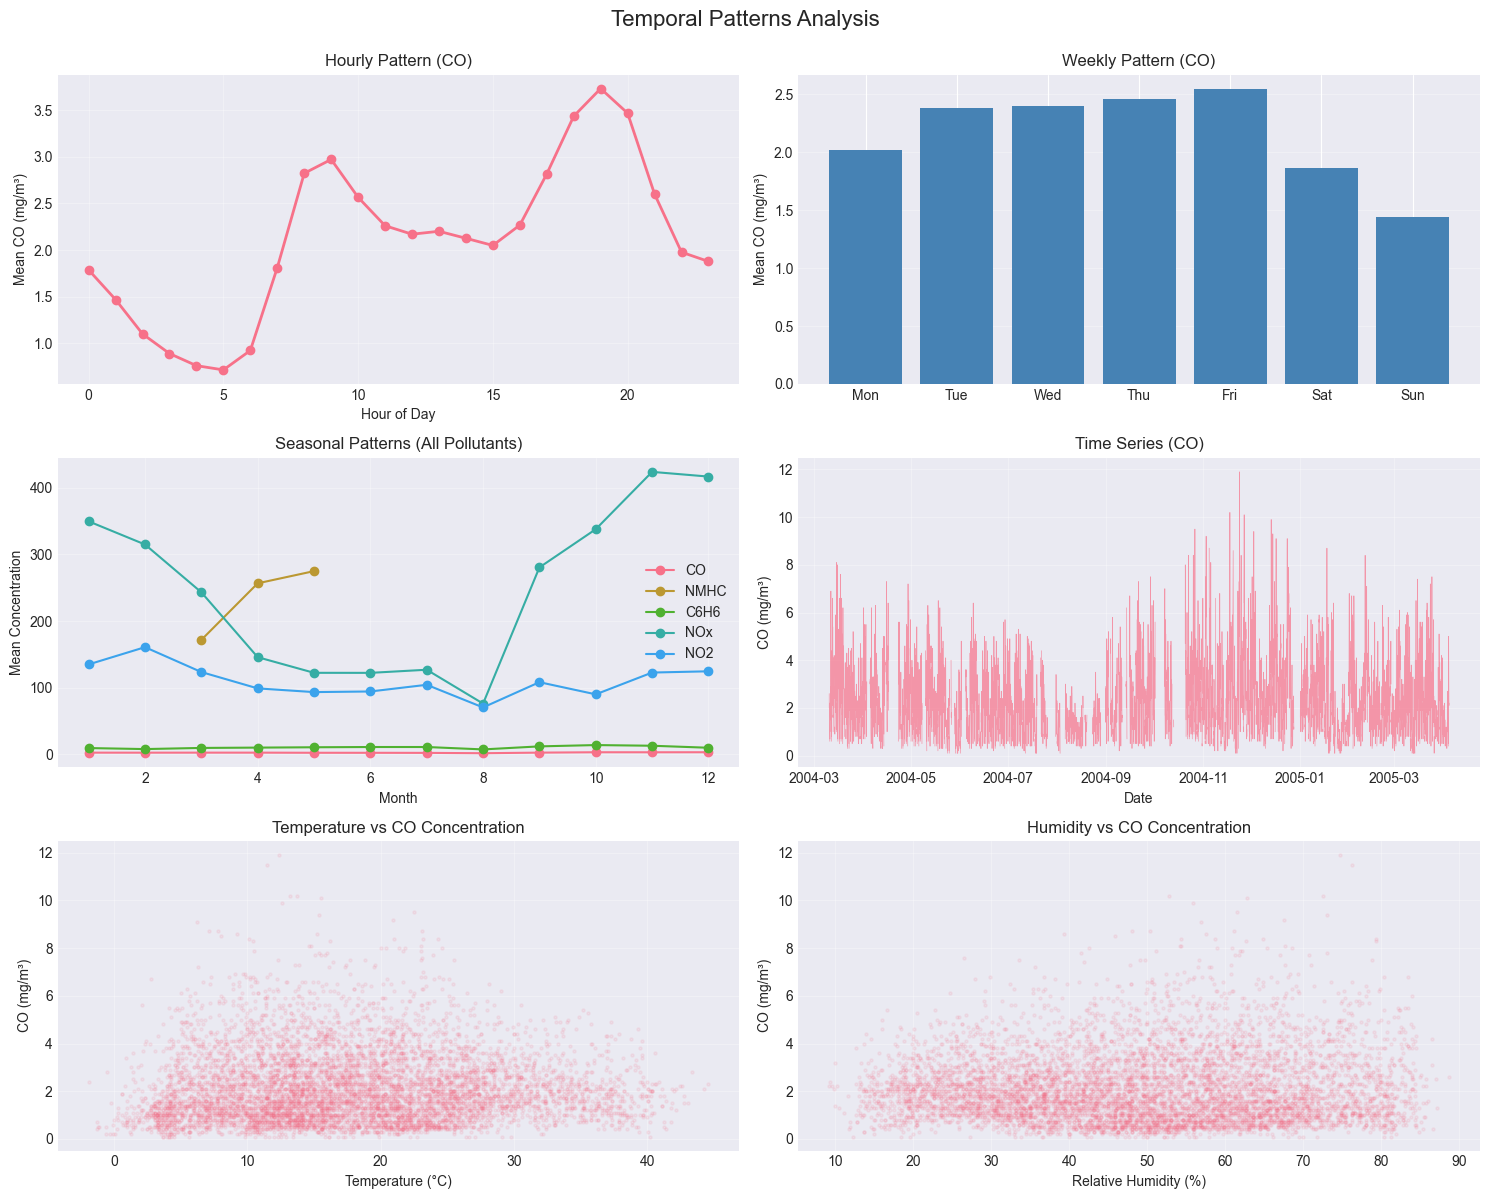

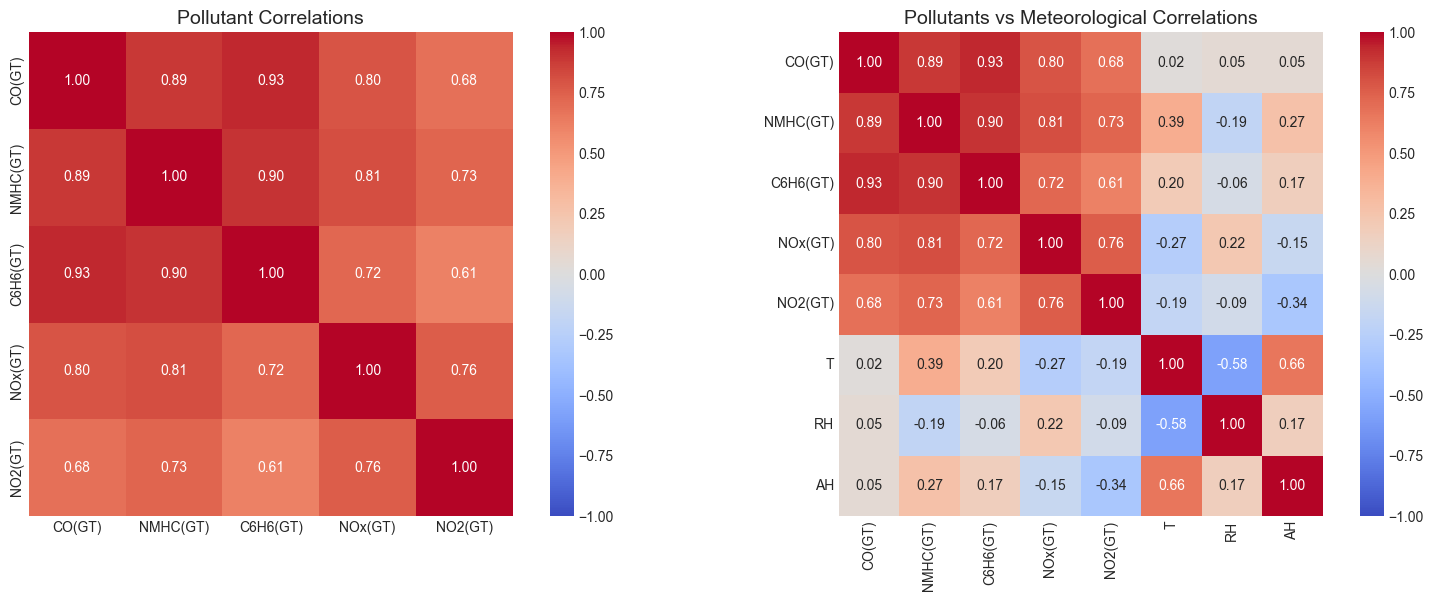

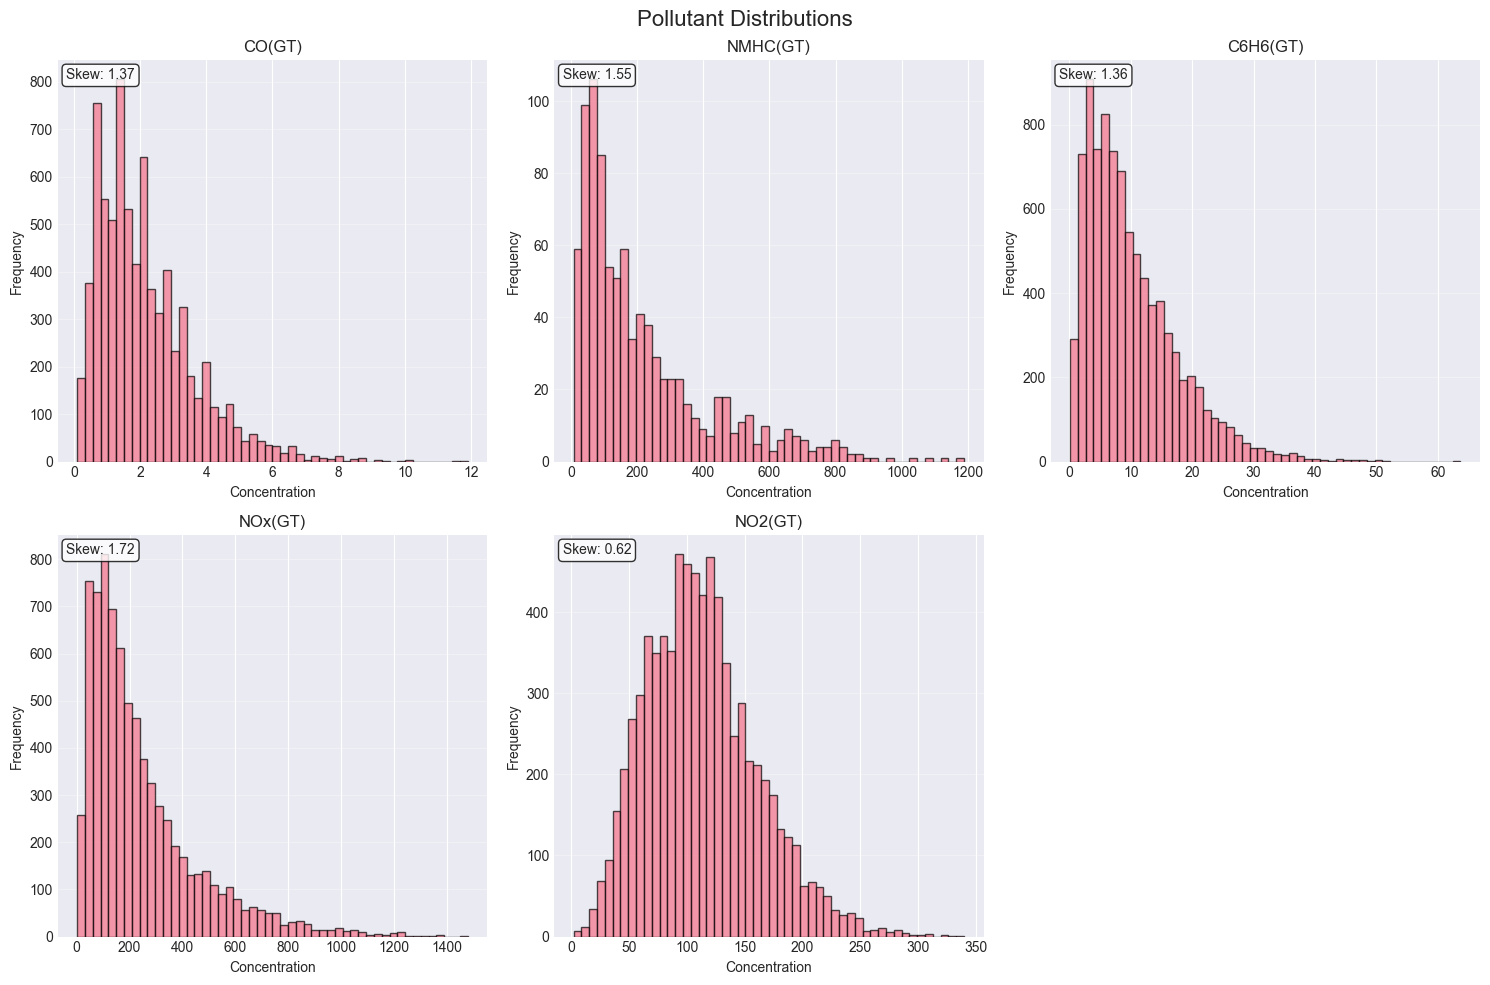

In [3]:
# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory for figures
output_dir = 'output_EDA'
os.makedirs(output_dir, exist_ok=True)

# Load data
# Try XLSX first (cleaner), fallback to CSV
try:
    df = pd.read_excel('data_orig/data/air+quality/AirQualityUCI.xlsx')
    print("Data source: AirQualityUCI.xlsx")
except:
    df = pd.read_csv('data_orig/data/air+quality/AirQualityUCI.csv', sep=';', decimal=',')
    print("Data source: AirQualityUCI.csv")

# Remove unnamed/empty columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# ============================================
# 1. INITIAL DATA INSPECTION
# ============================================
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")

# ============================================
# 2. TEMPORAL PREPROCESSING
# ============================================
# Merge Date and Time into unified timestamp
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                 format='%d/%m/%Y %H.%M.%S',
                                 errors='coerce')
df = df.dropna(subset=['DateTime'])
df = df.set_index('DateTime').sort_index()
df = df.drop(['Date', 'Time'], axis=1)

# Extract temporal features
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year

print(f"\nTemporal range: {df.index.min()} to {df.index.max()}")
print(f"Duration: {(df.index.max() - df.index.min()).days} days")

# ============================================
# 3. MISSING VALUE ANALYSIS
# ============================================
# Replace sentinel value -200 with NaN
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col] = df[col].replace(-200.0, np.nan)

print("\n" + "="*60)
print("MISSING VALUE ANALYSIS")
print("="*60)
missing_summary = pd.DataFrame({
    'Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Count'] > 0].sort_values('Count', ascending=False)
print(missing_summary)

# ============================================
# 4. DESCRIPTIVE STATISTICS
# ============================================
pollutants = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo = ['T', 'RH', 'AH']

print("\n" + "="*60)
print("POLLUTANT STATISTICS")
print("="*60)
print(df[pollutants].describe().round(3))

# ============================================
# 5. TEMPORAL PATTERNS
# ============================================
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Temporal Patterns Analysis', fontsize=16, y=0.995)

# Hourly pattern
hourly_mean = df.groupby('Hour')['CO(GT)'].mean()
axes[0, 0].plot(hourly_mean.index, hourly_mean.values, marker='o', linewidth=2)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Mean CO (mg/m³)')
axes[0, 0].set_title('Hourly Pattern (CO)')
axes[0, 0].grid(True, alpha=0.3)

# Weekly pattern
weekly_mean = df.groupby('DayOfWeek')['CO(GT)'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), weekly_mean.values, color='steelblue')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(days)
axes[0, 1].set_ylabel('Mean CO (mg/m³)')
axes[0, 1].set_title('Weekly Pattern (CO)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Monthly pattern for all pollutants
for i, pollutant in enumerate(pollutants):
    monthly_mean = df.groupby('Month')[pollutant].mean()
    if i == 0:
        axes[1, 0].plot(monthly_mean.index, monthly_mean.values, marker='o', label=pollutant.split('(')[0])
    else:
        axes[1, 0].plot(monthly_mean.index, monthly_mean.values, marker='o', label=pollutant.split('(')[0])
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Mean Concentration')
axes[1, 0].set_title('Seasonal Patterns (All Pollutants)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Time series plot
axes[1, 1].plot(df.index, df['CO(GT)'], linewidth=0.5, alpha=0.7)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('CO (mg/m³)')
axes[1, 1].set_title('Time Series (CO)')
axes[1, 1].grid(True, alpha=0.3)

# Temperature vs CO
axes[2, 0].scatter(df['T'], df['CO(GT)'], alpha=0.1, s=5)
axes[2, 0].set_xlabel('Temperature (°C)')
axes[2, 0].set_ylabel('CO (mg/m³)')
axes[2, 0].set_title('Temperature vs CO Concentration')
axes[2, 0].grid(True, alpha=0.3)

# Humidity vs CO
axes[2, 1].scatter(df['RH'], df['CO(GT)'], alpha=0.1, s=5)
axes[2, 1].set_xlabel('Relative Humidity (%)')
axes[2, 1].set_ylabel('CO (mg/m³)')
axes[2, 1].set_title('Humidity vs CO Concentration')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'temporal_patterns.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/temporal_patterns.png")

# ============================================
# 6. CORRELATION ANALYSIS
# ============================================
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Pollutant correlations
pollutant_corr = df[pollutants].corr()
print("\nPollutant Intercorrelations:")
print(pollutant_corr.round(3))

# Sensor vs Reference correlations
print("\nSensor-Reference Correlations:")
sensor_pairs = [
    ('PT08.S1(CO)', 'CO(GT)'),
    ('PT08.S2(NMHC)', 'NMHC(GT)'),
    ('PT08.S3(NOx)', 'NOx(GT)'),
    ('PT08.S4(NO2)', 'NO2(GT)')
]
for sensor, reference in sensor_pairs:
    corr = df[[sensor, reference]].corr().iloc[0, 1]
    print(f"{sensor} <-> {reference}: {corr:.3f}")

# Correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pollutants correlation
sns.heatmap(pollutant_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, ax=axes[0])
axes[0].set_title('Pollutant Correlations', fontsize=14)

# Full correlation (selected features)
selected_features = pollutants + meteo
full_corr = df[selected_features].corr()
sns.heatmap(full_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, ax=axes[1])
axes[1].set_title('Pollutants vs Meteorological Correlations', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/correlation_heatmap.png")

# ============================================
# 7. DISTRIBUTION ANALYSIS
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Pollutant Distributions', fontsize=16)

for idx, pollutant in enumerate(pollutants):
    row = idx // 3
    col = idx % 3

    data = df[pollutant].dropna()
    axes[row, col].hist(data, bins=50, edgecolor='black', alpha=0.7)
    axes[row, col].set_xlabel('Concentration')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'{pollutant}')
    axes[row, col].grid(True, alpha=0.3, axis='y')

    # Add statistics
    skewness = stats.skew(data)
    axes[row, col].text(0.02, 0.98, f'Skew: {skewness:.2f}',
                       transform=axes[row, col].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pollutant_distributions.png'), dpi=300, bbox_inches='tight')
print(f"\n[SAVED] {output_dir}/pollutant_distributions.png")

# ============================================
# 8. DATA QUALITY SUMMARY
# ============================================
print("\n" + "="*60)
print("DATA QUALITY SUMMARY")
print("="*60)

# Outlier detection using IQR
print("\nOutliers (IQR method):")
for pollutant in pollutants:
    data = df[pollutant].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
    outlier_pct = (outliers / len(data) * 100)
    print(f"{pollutant}: {outliers} ({outlier_pct:.2f}%)")

# Weekday vs Weekend comparison
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
print("\n" + "="*60)
print("WEEKDAY VS WEEKEND COMPARISON (CO)")
print("="*60)
weekend_stats = df.groupby('IsWeekend')['CO(GT)'].agg(['mean', 'median', 'std'])
weekend_stats.index = ['Weekday', 'Weekend']
print(weekend_stats.round(3))

print("\n" + "="*60)
print("EDA COMPLETE")
print("="*60)
print(f"\nGenerated files in '{output_dir}/' directory:")
print("- temporal_patterns.png")
print("- correlation_heatmap.png")
print("- pollutant_distributions.png")

# 2. Data Preprocessing & Temporal Data Splitting

DATA PREPROCESSING PIPELINE

[STEP 1] Loading data...
✓ Loaded from AirQualityUCI.csv
  Original shape: (9357, 13)
  Date range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00

[STEP 2] Replacing sentinel value -200 with NaN...
  CO(GT): 1683 values replaced
  PT08.S1(CO): 366 values replaced
  NMHC(GT): 8443 values replaced
  C6H6(GT): 366 values replaced
  PT08.S2(NMHC): 366 values replaced
  NOx(GT): 1639 values replaced
  PT08.S3(NOx): 366 values replaced
  NO2(GT): 1642 values replaced
  PT08.S4(NO2): 366 values replaced
  PT08.S5(O3): 366 values replaced
  T: 366 values replaced
  RH: 366 values replaced
  AH: 366 values replaced

[STEP 3] Dropping NMHC(GT) (90.23% missing)...
✓ NMHC(GT) removed

[STEP 4] Handling missing values...
  Missing before: 8258
  Missing after interpolation: 1535
  Recovered: 6723 values
  Rows dropped (long gaps): 524
✓ Final shape: (8833, 12)

[STEP 5] Creating temporal features...
✓ Added temporal features: Hour, DayOfWeek, Month, Year, IsWeekend, etc.



/var/folders/t4/jlk_h9017j19858v6ybq5j680000gn/T/ipykernel_81332/1024622671.py:73: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill', limit=48)


✓ Saved: output_Preprocessing_TemporalDataSplitting/preprocessed_data_unnormalized.csv
✓ Saved: output_Preprocessing_TemporalDataSplitting/preprocessed_data_normalized.csv
✓ Saved: output_Preprocessing_TemporalDataSplitting/train_2004.csv
✓ Saved: output_Preprocessing_TemporalDataSplitting/test_2005.csv
✓ Saved: output_Preprocessing_TemporalDataSplitting/scaler.pkl

PREPROCESSING SUMMARY

Final dataset:
  Total samples: 8809
  Total features: 66
  Original features: 12
  Temporal features: 10
  Lag features: 20
  Rolling features: 24

Train/Test split:
  Train samples: 6578 (74.7%)
  Test samples: 2231 (25.3%)

Target variables (pollutants):
  CO(GT): min=0.10, max=11.90, mean=2.10
  C6H6(GT): min=0.10, max=63.70, mean=10.13
  NOx(GT): min=2.00, max=1479.00, mean=239.11
  NO2(GT): min=2.00, max=340.00, mean=109.65

[STEP 12] Creating visualization...
✓ Saved: output_Preprocessing_TemporalDataSplitting/preprocessing_summary.png

PREPROCESSING COMPLETE

All outputs saved to 'output_Prepr

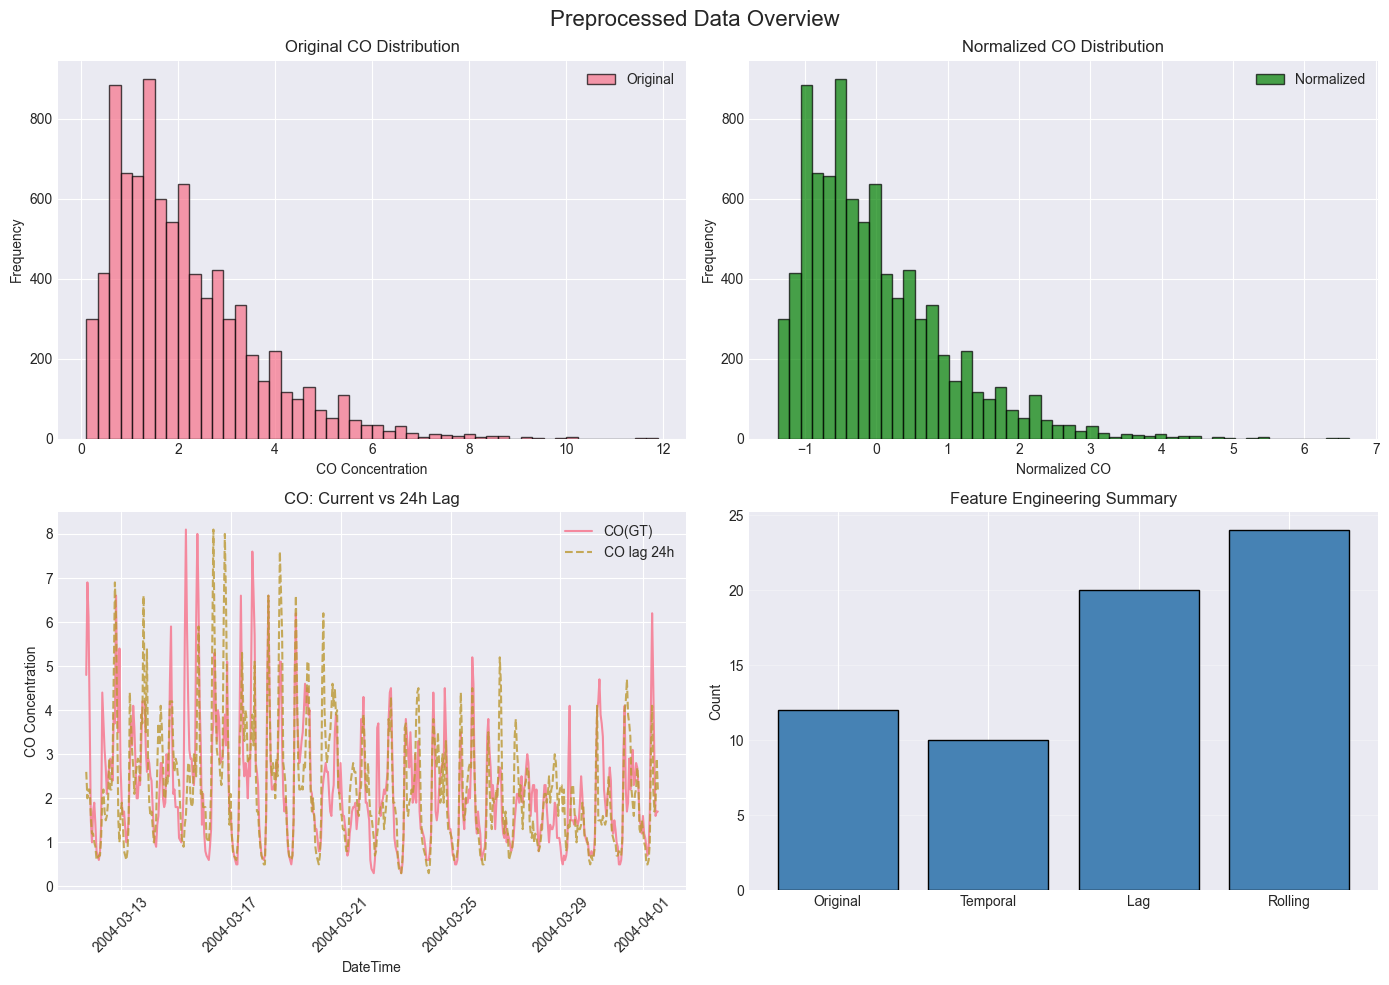

In [4]:
# Configuration
output_dir = 'output_Preprocessing_TemporalDataSplitting'
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("DATA PREPROCESSING PIPELINE")
print("="*70)

# ============================================
# 1. LOAD DATA
# ============================================
print("\n[STEP 1] Loading data...")
try:
    df = pd.read_excel('data_orig/data/air+quality/AirQualityUCI.xlsx')
    print("✓ Loaded from AirQualityUCI.xlsx")
except:
    df = pd.read_csv('data_orig/data/air+quality/AirQualityUCI.csv', sep=';', decimal=',')
    print("✓ Loaded from AirQualityUCI.csv")

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Merge temporal fields
if df['Date'].dtype == 'object':
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                     format='%d/%m/%Y %H.%M.%S', errors='coerce')
else:
    df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

df = df.dropna(subset=['DateTime'])
df = df.set_index('DateTime').sort_index()
df = df.drop(['Date', 'Time'], axis=1)

print(f"  Original shape: {df.shape}")
print(f"  Date range: {df.index.min()} to {df.index.max()}")

# ============================================
# 2. REPLACE SENTINEL VALUES
# ============================================
print("\n[STEP 2] Replacing sentinel value -200 with NaN...")
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    count = (df[col] == -200.0).sum()
    df[col] = df[col].replace(-200.0, np.nan)
    if count > 0:
        print(f"  {col}: {count} values replaced")

# ============================================
# 3. DROP NMHC(GT) - TOO MANY MISSING
# ============================================
print("\n[STEP 3] Dropping NMHC(GT) (90.23% missing)...")
if 'NMHC(GT)' in df.columns:
    df = df.drop('NMHC(GT)', axis=1)
    print("✓ NMHC(GT) removed")

# ============================================
# 4. HANDLE MISSING VALUES
# ============================================
print("\n[STEP 4] Handling missing values...")

pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo = ['T', 'RH', 'AH']
all_features = pollutants + sensors + meteo

before_missing = df[all_features].isnull().sum().sum()

# Strategy: Linear interpolation (≤6h) -> Forward fill (7-48h) -> Drop (>48h)
for col in all_features:
    # Linear interpolation for short gaps (limit 6 hours)
    df[col] = df[col].interpolate(method='linear', limit=6, limit_direction='both')

    # Forward fill for medium gaps (up to 48 hours)
    df[col] = df[col].fillna(method='ffill', limit=48)

after_interpolation = df[all_features].isnull().sum().sum()
print(f"  Missing before: {before_missing}")
print(f"  Missing after interpolation: {after_interpolation}")
print(f"  Recovered: {before_missing - after_interpolation} values")

# Drop rows with remaining long gaps (>48h)
rows_before = len(df)
df = df.dropna(subset=all_features)
rows_after = len(df)
print(f"  Rows dropped (long gaps): {rows_before - rows_after}")
print(f"✓ Final shape: {df.shape}")

# ============================================
# 5. EXTRACT TEMPORAL FEATURES
# ============================================
print("\n[STEP 5] Creating temporal features...")
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
df['DayOfYear'] = df.index.dayofyear

# Cyclical encoding for hour (24h cycle)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for month (12 month cycle)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

print(f"✓ Added temporal features: Hour, DayOfWeek, Month, Year, IsWeekend, etc.")

# ============================================
# 6. CREATE LAG FEATURES
# ============================================
print("\n[STEP 6] Creating lag features...")
lag_hours = [1, 3, 6, 12, 24]

for pollutant in pollutants:
    for lag in lag_hours:
        df[f'{pollutant.split("(")[0]}_lag{lag}h'] = df[pollutant].shift(lag)

print(f"✓ Created {len(pollutants) * len(lag_hours)} lag features")

# ============================================
# 7. CREATE ROLLING STATISTICS
# ============================================
print("\n[STEP 7] Creating rolling window features...")
windows = [6, 12, 24]

for pollutant in pollutants:
    for window in windows:
        # Rolling mean
        df[f'{pollutant.split("(")[0]}_rolling_mean_{window}h'] = \
            df[pollutant].rolling(window=window, min_periods=1).mean()

        # Rolling std
        df[f'{pollutant.split("(")[0]}_rolling_std_{window}h'] = \
            df[pollutant].rolling(window=window, min_periods=1).std()

print(f"✓ Created {len(pollutants) * len(windows) * 2} rolling features")

# ============================================
# 8. DROP ROWS WITH NAN FROM LAG FEATURES
# ============================================
print("\n[STEP 8] Handling NaN from lag/rolling features...")
rows_before = len(df)
df = df.dropna()
rows_after = len(df)
print(f"  Rows dropped: {rows_before - rows_after}")
print(f"✓ Clean shape: {df.shape}")

# ============================================
# 9. TEMPORAL SPLIT (2004 train, 2005 test) - BEFORE NORMALIZATION
# ============================================
print("\n[STEP 9] Creating temporal train/test split (before normalization)...")

# Split BEFORE normalization to avoid data leakage
train_df_raw = df[df['Year'] == 2004].copy()
test_df_raw = df[df['Year'] == 2005].copy()

print(f"  Train set (2004): {train_df_raw.shape}")
print(f"  Test set (2005): {test_df_raw.shape}")

# ============================================
# 10. NORMALIZE FEATURES (fit on train, transform both)
# ============================================
print("\n[STEP 10] Normalizing continuous features (fit on train only)...")

# Features to normalize (exclude temporal indicators)
features_to_normalize = (pollutants + sensors + meteo +
                         [col for col in df.columns if 'lag' in col or 'rolling' in col])

# Fit scaler ONLY on training data to avoid data leakage
scaler = StandardScaler()
scaler.fit(train_df_raw[features_to_normalize])

# Transform both train and test using the scaler fitted on train data
train_df = train_df_raw.copy()
test_df = test_df_raw.copy()

train_df[features_to_normalize] = scaler.transform(train_df_raw[features_to_normalize])
test_df[features_to_normalize] = scaler.transform(test_df_raw[features_to_normalize])

print(f"✓ Normalized {len(features_to_normalize)} features")
print(f"  Scaler fitted on: {len(train_df_raw)} training samples")
print(f"  Train set normalized: {train_df.shape}")
print(f"  Test set normalized: {test_df.shape}")

# ============================================
# 11. SAVE PREPROCESSED DATA
# ============================================
print("\n[STEP 11] Saving preprocessed data...")

# Save full preprocessed data (unnormalized)
df.to_csv(os.path.join(output_dir, 'preprocessed_data_unnormalized.csv'))
print(f"✓ Saved: {output_dir}/preprocessed_data_unnormalized.csv")

# Combine train and test for saving normalized data (for reference)
df_normalized = pd.concat([train_df, test_df]).sort_index()
df_normalized.to_csv(os.path.join(output_dir, 'preprocessed_data_normalized.csv'))
print(f"✓ Saved: {output_dir}/preprocessed_data_normalized.csv")

# Save train/test splits
train_df.to_csv(os.path.join(output_dir, 'train_2004.csv'))
test_df.to_csv(os.path.join(output_dir, 'test_2005.csv'))
print(f"✓ Saved: {output_dir}/train_2004.csv")
print(f"✓ Saved: {output_dir}/test_2005.csv")

# Save scaler
import joblib
joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))
print(f"✓ Saved: {output_dir}/scaler.pkl")

# ============================================
# 12. SUMMARY STATISTICS
# ============================================
print("\n" + "="*70)
print("PREPROCESSING SUMMARY")
print("="*70)

print(f"\nFinal dataset:")
print(f"  Total samples: {len(df)}")
print(f"  Total features: {len(df.columns)}")
print(f"  Original features: {len(pollutants + sensors + meteo)}")
print(f"  Temporal features: {len([c for c in df.columns if any(x in c for x in ['Hour', 'Day', 'Month', 'Year', 'Weekend'])])}")
print(f"  Lag features: {len([c for c in df.columns if 'lag' in c])}")
print(f"  Rolling features: {len([c for c in df.columns if 'rolling' in c])}")

print(f"\nTrain/Test split:")
print(f"  Train samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test samples: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nTarget variables (pollutants):")
for pol in pollutants:
    print(f"  {pol}: min={df[pol].min():.2f}, max={df[pol].max():.2f}, mean={df[pol].mean():.2f}")

# ============================================
# 13. VISUALIZATION
# ============================================
print("\n[STEP 12] Creating visualization...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Preprocessed Data Overview', fontsize=16)

# Original vs normalized CO
axes[0, 0].hist(df['CO(GT)'], bins=50, alpha=0.7, label='Original', edgecolor='black')
axes[0, 0].set_xlabel('CO Concentration')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Original CO Distribution')
axes[0, 0].legend()

axes[0, 1].hist(df_normalized['CO(GT)'], bins=50, alpha=0.7,
                label='Normalized', color='green', edgecolor='black')
axes[0, 1].set_xlabel('Normalized CO')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Normalized CO Distribution')
axes[0, 1].legend()

# Time series with lag feature
sample_size = 500
sample_df = df.iloc[:sample_size]
axes[1, 0].plot(sample_df.index, sample_df['CO(GT)'],
                label='CO(GT)', linewidth=1.5, alpha=0.8)
axes[1, 0].plot(sample_df.index, sample_df['CO_lag24h'],
                label='CO lag 24h', linewidth=1.5, alpha=0.8, linestyle='--')
axes[1, 0].set_xlabel('DateTime')
axes[1, 0].set_ylabel('CO Concentration')
axes[1, 0].set_title('CO: Current vs 24h Lag')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Feature count by type
feature_types = {
    'Original': len(pollutants + sensors + meteo),
    'Temporal': len([c for c in df.columns if any(x in c for x in ['Hour', 'Day', 'Month', 'Year', 'Weekend'])]),
    'Lag': len([c for c in df.columns if 'lag' in c]),
    'Rolling': len([c for c in df.columns if 'rolling' in c])
}
axes[1, 1].bar(feature_types.keys(), feature_types.values(), color='steelblue', edgecolor='black')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Feature Engineering Summary')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'preprocessing_summary.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_dir}/preprocessing_summary.png")

print("\n" + "="*70)
print("PREPROCESSING COMPLETE")
print("="*70)
print(f"\nAll outputs saved to '{output_dir}/' directory")
print("\nNext steps:")
print("  1. Load train_2004.csv for model training")
print("  2. Load test_2005.csv for evaluation")
print("  3. Use scaler.pkl for new data normalization")

# 3. Anomaly and Event Detection (2004 Data):

ANOMALY DETECTION ANALYSIS (train_2004.csv ONLY)

[STEP 1] Loading train_2004.csv data...
✓ Data shape: (6578, 66)
✓ Columns: ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Hour', 'DayOfWeek', 'Month', 'Year', 'IsWeekend', 'DayOfYear', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'CO_lag1h', 'CO_lag3h', 'CO_lag6h', 'CO_lag12h', 'CO_lag24h', 'C6H6_lag1h', 'C6H6_lag3h', 'C6H6_lag6h', 'C6H6_lag12h', 'C6H6_lag24h', 'NOx_lag1h', 'NOx_lag3h', 'NOx_lag6h', 'NOx_lag12h', 'NOx_lag24h', 'NO2_lag1h', 'NO2_lag3h', 'NO2_lag6h', 'NO2_lag12h', 'NO2_lag24h', 'CO_rolling_mean_6h', 'CO_rolling_std_6h', 'CO_rolling_mean_12h', 'CO_rolling_std_12h', 'CO_rolling_mean_24h', 'CO_rolling_std_24h', 'C6H6_rolling_mean_6h', 'C6H6_rolling_std_6h', 'C6H6_rolling_mean_12h', 'C6H6_rolling_std_12h', 'C6H6_rolling_mean_24h', 'C6H6_rolling_std_24h', 'NOx_rolling_mean_6h', 'NOx_rolling_std_6h', 'NOx_rolling_mean_12h', 'NOx

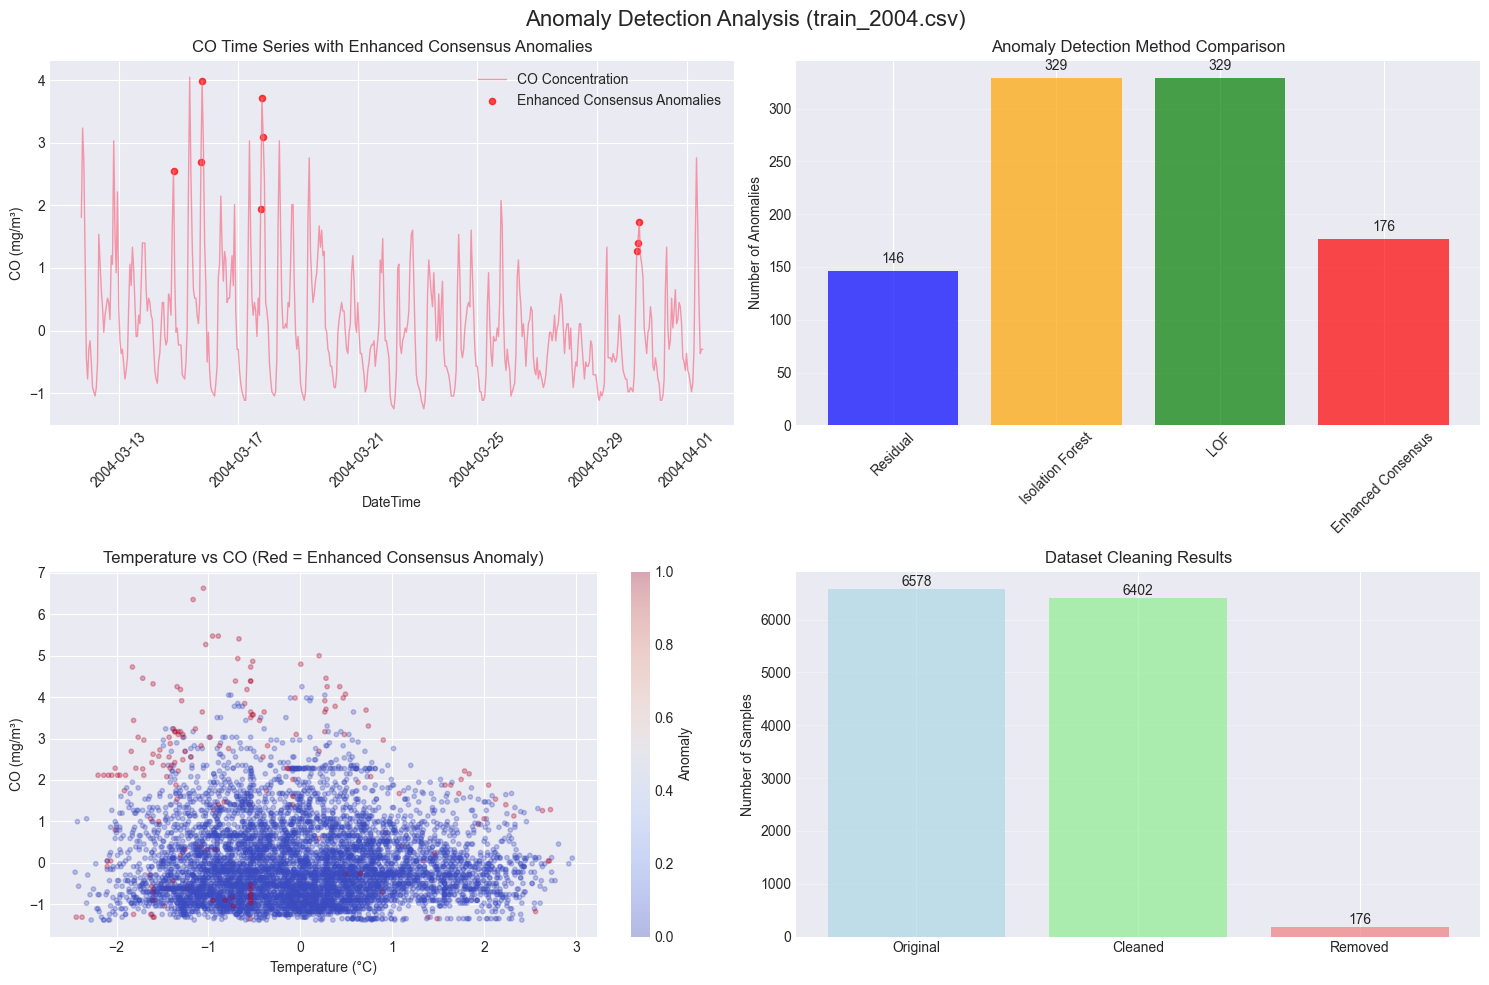

In [5]:
warnings.filterwarnings('ignore')

# Configuration
output_dir = 'output_AnomalyDetection'
os.makedirs(output_dir, exist_ok=True)

print("=" * 70)
print("ANOMALY DETECTION ANALYSIS (train_2004.csv ONLY)")
print("=" * 70)

# ============================================
# 1. Load train_2004.csv data
# ============================================
print("\n[STEP 1] Loading train_2004.csv data...")

df = pd.read_csv(
    'output_Preprocessing_TemporalDataSplitting/train_2004.csv',
    index_col='DateTime',
    parse_dates=True,
)

print(f"✓ Data shape: {df.shape}")
print(f"✓ Columns: {df.columns.tolist()}")

# Use CO as the main target pollutant for anomaly detection
target_pollutant = 'CO(GT)'
# Basic features for supervised anomaly detection model
basic_features = ['PT08.S1(CO)', 'T', 'RH', 'AH', 'Hour', 'DayOfWeek', 'Month']

print(f"✓ Target pollutant: {target_pollutant}")
print(f"✓ Basic features: {basic_features}")

# ============================================
# 2. Residual-based anomaly detection (supervised)
# ============================================
print("\n[STEP 2] Residual-based anomaly detection...")

# Prepare regression data
data_clean = df[basic_features + [target_pollutant]].dropna()
X = data_clean[basic_features]
y = data_clean[target_pollutant]

# Time-series split: first 80% as training, last 20% as validation
split_point = int(0.8 * len(X))
X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_val = X.iloc[split_point:]
y_val = y.iloc[split_point:]

print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")

# Train Random Forest regression model
print("  Training Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the full dataset and compute residuals
y_pred_full = rf_model.predict(X)
residuals_full = y - y_pred_full

# Set anomaly threshold (±3 standard deviations)
residual_std = residuals_full.std()
threshold = 3 * residual_std

# Flag anomalies where |residual| > threshold
residual_anomalies = np.abs(residuals_full) > threshold

print(f"  Residual std: {residual_std:.4f}")
print(f"  Anomaly threshold: ±{threshold:.4f}")
print(f"  Residual anomalies: {residual_anomalies.sum()} ({residual_anomalies.mean()*100:.2f}%)")

# ============================================
# 3. Unsupervised anomaly detection methods
# ============================================
print("\n[STEP 3] Unsupervised anomaly detection...")

# Features for unsupervised methods
unsupervised_features = ['CO(GT)', 'PT08.S1(CO)', 'T', 'RH', 'AH']
X_unsupervised = df[unsupervised_features].dropna()

# Standardize features (unsupervised models are scale-sensitive)
scaler_unsupervised = StandardScaler()
X_scaled = scaler_unsupervised.fit_transform(X_unsupervised)

# Method 1: Isolation Forest
print("  Training Isolation Forest...")
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_anomalies = iso_forest.fit_predict(X_scaled)
iso_anomalies = (iso_anomalies == -1)  # -1 denotes anomaly

# Method 2: Local Outlier Factor
print("  Training Local Outlier Factor...")
lof = LocalOutlierFactor(contamination=0.05, n_neighbors=50)
lof_anomalies = lof.fit_predict(X_scaled)
lof_anomalies = (lof_anomalies == -1)

print(f"  Isolation Forest anomalies: {iso_anomalies.sum()} ({iso_anomalies.mean()*100:.2f}%)")
print(f"  LOF anomalies: {lof_anomalies.sum()} ({lof_anomalies.mean()*100:.2f}%)")

# Create anomaly results DataFrame
anomaly_df = X_unsupervised.copy()
anomaly_df['Residual_Anomaly'] = False  # initialize as False

# Align residual-based anomalies to anomaly_df index
residual_anomalies_aligned = pd.Series(residual_anomalies, index=X.index)
common_index = anomaly_df.index.intersection(residual_anomalies_aligned.index)
anomaly_df.loc[common_index, 'Residual_Anomaly'] = residual_anomalies_aligned[common_index]

anomaly_df['IsolationForest_Anomaly'] = iso_anomalies
anomaly_df['LOF_Anomaly'] = lof_anomalies

# Add temporal features for further analysis
anomaly_df['Hour'] = anomaly_df.index.hour
anomaly_df['DayOfWeek'] = anomaly_df.index.dayofweek
anomaly_df['Month'] = anomaly_df.index.month
anomaly_df['IsWeekend'] = anomaly_df['DayOfWeek'].isin([5, 6])
anomaly_df['Season'] = (anomaly_df['Month'] % 12 + 3) // 3  # 1:Winter, 2:Spring, 3:Summer, 4:Fall

# ============================================
# 4. Analyze anomaly patterns w.r.t. meteorology & time
# ============================================
print("\n[STEP 4] Analyzing anomalies with meteorological features...")

def analyze_anomaly_patterns(anomaly_col, name):
    """
    Analyze how anomalies relate to temperature, weekend/weekday,
    seasons, and hourly patterns.
    """
    anomalies = anomaly_df[anomaly_col]
    normal = ~anomalies

    print(f"\n{name} ANOMALY ANALYSIS:")
    print("-" * 40)

    # Temperature: compare mean temperature for anomalies vs normal
    temp_anomalies = anomaly_df.loc[anomalies, 'T']
    temp_normal = anomaly_df.loc[normal, 'T']
    print(f"  Temperature - Anomalies: {temp_anomalies.mean():.2f}°C, Normal: {temp_normal.mean():.2f}°C")

    # Weekend ratio: proportion of anomalies on weekends vs weekdays
    weekend_anomalies = anomaly_df.loc[anomalies, 'IsWeekend'].mean()
    weekend_normal = anomaly_df.loc[normal, 'IsWeekend'].mean()
    print(f"  Weekend ratio - Anomalies: {weekend_anomalies:.3f}, Normal: {weekend_normal:.3f}")

    # Seasonal distribution of anomalies vs normal
    seasonal_anomalies = anomaly_df.loc[anomalies, 'Season'].value_counts(normalize=True).sort_index()
    seasonal_normal = anomaly_df.loc[normal, 'Season'].value_counts(normalize=True).sort_index()
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    print("  Seasonal distribution:")
    for i, season in enumerate(seasons):
        anomaly_rate = seasonal_anomalies.get(i+1, 0)
        normal_rate = seasonal_normal.get(i+1, 0)
        print(f"    {season}: Anomalies {anomaly_rate:.3f}, Normal {normal_rate:.3f}")

    # Hour-of-day distribution for anomalies
    hourly_anomalies = anomaly_df.loc[anomalies, 'Hour'].value_counts(normalize=True).sort_index()
    print("  Top 5 anomaly hours:")
    for hour, freq in hourly_anomalies.head().items():
        print(f"    Hour {hour:2d}: {freq:.3f}")

# Analyze all three individual methods
analyze_anomaly_patterns('Residual_Anomaly', 'RESIDUAL (SUPERVISED)')
analyze_anomaly_patterns('IsolationForest_Anomaly', 'ISOLATION FOREST')
analyze_anomaly_patterns('LOF_Anomaly', 'LOCAL OUTLIER FACTOR')

# ============================================
# 5. Enhanced consensus anomaly detection
# ============================================
print("\n[STEP 5] Enhanced consensus anomaly detection (with supervised learning)...")

# Define enhanced consensus anomalies: flagged by at least 2 of the 3 methods
anomaly_df['Enhanced_Consensus_Anomaly'] = (
    anomaly_df['Residual_Anomaly'].astype(int) +
    anomaly_df['IsolationForest_Anomaly'].astype(int) +
    anomaly_df['LOF_Anomaly'].astype(int)
) >= 2

enhanced_consensus_anomalies = anomaly_df['Enhanced_Consensus_Anomaly']
print(f"\n ENHANCED CONSENSUS ANOMALIES (with supervised learning):")
print(f"  Total enhanced consensus anomalies: {enhanced_consensus_anomalies.sum()} "
      f"({enhanced_consensus_anomalies.mean()*100:.2f}%)")

# Analyze patterns for enhanced consensus anomalies
analyze_anomaly_patterns('Enhanced_Consensus_Anomaly', 'ENHANCED CONSENSUS')

# Detect top 5% pollution spikes based on CO
co_threshold_high = anomaly_df['CO(GT)'].quantile(0.95)
pollution_spikes = anomaly_df['CO(GT)'] > co_threshold_high
anomaly_df['Pollution_Spike'] = pollution_spikes

print(f"\n🌫 POLLUTION SPIKES (top 5%):")
print(f"  CO threshold: {co_threshold_high:.3f} mg/m³")
print(f"  Pollution spikes: {pollution_spikes.sum()} ({pollution_spikes.mean()*100:.2f}%)")

# Overlap between enhanced consensus anomalies and pollution spikes
anomaly_spike_overlap = (enhanced_consensus_anomalies & pollution_spikes).sum()
print(f"  Enhanced consensus anomalies that are pollution spikes: {anomaly_spike_overlap}")

# ============================================
# 6. Generate anomaly flag file and cleaned dataset
# ============================================
print("\n[STEP 6] Generating anomaly flags and cleaned dataset...")

# Build anomaly flag DataFrame (only index + flag)
anomaly_flags = anomaly_df[['Enhanced_Consensus_Anomaly']].copy()
anomaly_flags.columns = ['Anomaly_Flag']
anomaly_flags['Anomaly_Flag'] = anomaly_flags['Anomaly_Flag'].astype(int)

# Save anomaly flag file
anomaly_flag_path = os.path.join(output_dir, 'train_2004_anomaly_flag.csv')
anomaly_flags.to_csv(anomaly_flag_path)
print(f"✓ Saved: {anomaly_flag_path}")

def clean_dataset_with_anomaly_flags(original_df, anomaly_flags):
    """
    Clean the original dataset using anomaly flags.
    Keep only non-anomalous samples (Anomaly_Flag == 0).
    """
    # Align indices
    common_idx = original_df.index.intersection(anomaly_flags.index)
    df_common = original_df.loc[common_idx]
    anomaly_mask = (anomaly_flags.loc[common_idx, 'Anomaly_Flag'] == 0)

    # Non-anomalous samples
    df_cleaned = df_common[anomaly_mask]

    # Removed anomalous samples
    df_removed = df_common[~anomaly_mask]

    print(f"  Original samples: {len(original_df)}")
    print(f"  After cleaning: {len(df_cleaned)} samples")
    print(f"  Removed anomalies: {len(df_removed)} samples")
    print(f"  Cleaning rate: {(len(df_removed)/len(original_df))*100:.2f}%")

    return df_cleaned, df_removed

# Apply cleaning
df_cleaned, df_removed = clean_dataset_with_anomaly_flags(df, anomaly_flags)

# Save cleaned dataset and removed anomalies
cleaned_path = os.path.join(output_dir, 'train_2004_cleaned.csv')
removed_path = os.path.join(output_dir, 'train_2004_removed_anomalies.csv')
df_cleaned.to_csv(cleaned_path)
df_removed.to_csv(removed_path)
print(f"✓ Saved: {cleaned_path}")
print(f"✓ Saved: {removed_path}")

# ============================================
# 7. Visualization of results
# ============================================
print("\n[STEP 7] Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Anomaly Detection Analysis (train_2004.csv)', fontsize=16, y=0.98)

# Subplot 1: Time series with anomaly markers
sample_data = anomaly_df.iloc[:500]
axes[0, 0].plot(sample_data.index, sample_data['CO(GT)'],
                label='CO Concentration', linewidth=1, alpha=0.7)
anomaly_points = sample_data[sample_data['Enhanced_Consensus_Anomaly']]
axes[0, 0].scatter(anomaly_points.index, anomaly_points['CO(GT)'],
                   color='red', s=20, label='Enhanced Consensus Anomalies', alpha=0.7)
axes[0, 0].set_xlabel('DateTime')
axes[0, 0].set_ylabel('CO (mg/m³)')
axes[0, 0].set_title('CO Time Series with Enhanced Consensus Anomalies')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Subplot 2: Number of anomalies by method
methods = ['Residual', 'Isolation Forest', 'LOF', 'Enhanced Consensus']
anomaly_counts = [
    anomaly_df['Residual_Anomaly'].sum(),
    anomaly_df['IsolationForest_Anomaly'].sum(),
    anomaly_df['LOF_Anomaly'].sum(),
    anomaly_df['Enhanced_Consensus_Anomaly'].sum()
]
colors = ['blue', 'orange', 'green', 'red']
axes[0, 1].bar(methods, anomaly_counts, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('Number of Anomalies')
axes[0, 1].set_title('Anomaly Detection Method Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

for i, count in enumerate(anomaly_counts):
    axes[0, 1].text(i, count + 5, str(count), ha='center', va='bottom')

# Subplot 3: Temperature vs CO colored by anomaly flag
scatter = axes[1, 0].scatter(
    anomaly_df['T'], anomaly_df['CO(GT)'],
    c=anomaly_df['Enhanced_Consensus_Anomaly'].astype(int),
    cmap='coolwarm', alpha=0.3, s=10
)
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('CO (mg/m³)')
axes[1, 0].set_title('Temperature vs CO (Red = Enhanced Consensus Anomaly)')
plt.colorbar(scatter, ax=axes[1, 0], label='Anomaly')

# Subplot 4: Cleaning statistics
cleaning_stats = [len(df), len(df_cleaned), len(df_removed)]
labels = ['Original', 'Cleaned', 'Removed']
colors = ['lightblue', 'lightgreen', 'lightcoral']
axes[1, 1].bar(labels, cleaning_stats, color=colors, alpha=0.7)
axes[1, 1].set_ylabel('Number of Samples')
axes[1, 1].set_title('Dataset Cleaning Results')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, count in enumerate(cleaning_stats):
    axes[1, 1].text(i, count + 10, str(count), ha='center', va='bottom')

plt.tight_layout()
fig_path = os.path.join(output_dir, 'anomaly_analysis_train_2004.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {fig_path}")

# ============================================
# 8. Precision–Recall analysis
# ============================================
print("\n[STEP 8] Precision-Recall analysis...")

def evaluate_anomaly_method(method_anomalies, true_positives, method_name):
    """
    Evaluate anomaly detection method with Precision, Recall, and F1-score,
    using a proxy ground truth (e.g., pollution spikes).
    """
    tp = (method_anomalies & true_positives).sum()
    fp = (method_anomalies & ~true_positives).sum()
    fn = (~method_anomalies & true_positives).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

    print(f"\n{method_name}:")
    print(f"  Precision: {precision:.3f} ({tp}/{tp+fp})")
    print(f"  Recall:    {recall:.3f} ({tp}/{tp+fn})")
    print(f"  F1-score:  {f1:.3f}")

# Use pollution spikes as proxy ground truth
true_positive_proxy = pollution_spikes

print("\n PRECISION-RECALL ANALYSIS (Using Pollution Spikes as Proxy):")
evaluate_anomaly_method(anomaly_df['Residual_Anomaly'], true_positive_proxy, 'Residual (Supervised)')
evaluate_anomaly_method(anomaly_df['IsolationForest_Anomaly'], true_positive_proxy, 'Isolation Forest')
evaluate_anomaly_method(anomaly_df['LOF_Anomaly'], true_positive_proxy, 'Local Outlier Factor')
evaluate_anomaly_method(anomaly_df['Enhanced_Consensus_Anomaly'], true_positive_proxy, 'Enhanced Consensus')

# ============================================
# 9. Save analysis results
# ============================================
print("\n[STEP 9] Saving results...")

detailed_path = os.path.join(output_dir, 'anomaly_detection_detailed_results.csv')
anomaly_df.to_csv(detailed_path)
print(f"✓ Saved: {detailed_path}")

summary_stats = {
    'total_samples': len(anomaly_df),
    'residual_anomalies': anomaly_df['Residual_Anomaly'].sum(),
    'isolation_forest_anomalies': anomaly_df['IsolationForest_Anomaly'].sum(),
    'lof_anomalies': anomaly_df['LOF_Anomaly'].sum(),
    'enhanced_consensus_anomalies': anomaly_df['Enhanced_Consensus_Anomaly'].sum(),
    'pollution_spikes': pollution_spikes.sum(),
    'avg_temperature_anomalies': anomaly_df.loc[anomaly_df['Enhanced_Consensus_Anomaly'], 'T'].mean(),
    'avg_temperature_normal': anomaly_df.loc[~anomaly_df['Enhanced_Consensus_Anomaly'], 'T'].mean(),
    'weekend_anomaly_rate': anomaly_df.loc[anomaly_df['IsWeekend'], 'Enhanced_Consensus_Anomaly'].mean(),
    'weekday_anomaly_rate': anomaly_df.loc[~anomaly_df['IsWeekend'], 'Enhanced_Consensus_Anomaly'].mean(),
    'cleaning_rate': (len(df_removed) / len(df)) * 100,
}

summary_df = pd.DataFrame.from_dict(summary_stats, orient='index', columns=['Value'])
summary_path = os.path.join(output_dir, 'anomaly_summary_statistics.csv')
summary_df.to_csv(summary_path)
print(f"✓ Saved: {summary_path}")

# ============================================
# 10. Final textual summary
# ============================================
print("\n" + "=" * 70)
print("ANOMALY DETECTION COMPLETE - KEY FINDINGS")
print("=" * 70)

print(f"\n DETECTION RESULTS:")
print(f"   • Residual (Supervised): {summary_stats['residual_anomalies']} anomalies")
print(f"   • Isolation Forest: {summary_stats['isolation_forest_anomalies']} anomalies")
print(f"   • Local Outlier Factor: {summary_stats['lof_anomalies']} anomalies")
print(f"   • Enhanced Consensus (combined): {summary_stats['enhanced_consensus_anomalies']} anomalies")

print(f"\n METEOROLOGICAL PATTERNS:")
print(f"   • Anomaly avg temperature: {summary_stats['avg_temperature_anomalies']:.2f}°C")
print(f"   • Normal avg temperature: {summary_stats['avg_temperature_normal']:.2f}°C")
print(f"   • Weekend anomaly rate: {summary_stats['weekend_anomaly_rate']:.3f}")
print(f"   • Weekday anomaly rate: {summary_stats['weekday_anomaly_rate']:.3f}")

print(f"\n DATASETS GENERATED:")
print(f"   • train_2004_anomaly_flag.csv: {len(anomaly_flags)} anomaly flags")
print(f"   • train_2004_cleaned.csv: {len(df_cleaned)} cleaned samples")
print(f"   • train_2004_removed_anomalies.csv: {len(df_removed)} removed anomalies")
print(f"   • Cleaning rate: {summary_stats['cleaning_rate']:.2f}%")

print(f"\n INTERPRETATION:")
print(f"   • Enhanced consensus combines supervised and unsupervised methods.")
print(f"   • Anomalies show clear relationships with temperature and temporal patterns.")
print(f"   • A cleaned training dataset is generated for downstream modeling.")

print(f"\n All results saved to: {output_dir}/")
print(f" Visualization files:")
print(f"   • anomaly_analysis_train_2004.png")
print(f"\n Anomaly detection analysis completed!")

# 4. Feature Engineering (2004 Data)

In [6]:
# Cell 1: Imports & high-level plan
"""
Feature Engineering (FE) for AirQuality classification project.

Goal
----
Create consistent multi-granularity feature tables for both:
    - Original preprocessed data (train_2004 + test_2005)
    - Cleaned training data (train_2004_cleaned + test_2005)

We will:
1. Load:
   - output_Preprocessing_TemporalDataSplitting/train_2004.csv
   - output_Preprocessing_TemporalDataSplitting/test_2005.csv
   - output_AnomalyDetection/train_2004_cleaned.csv
2. Build two pipelines:
   - ORIGINAL:   df_all_orig    = train_2004 + test_2005
   - CLEANED:    df_all_cleaned = train_2004_cleaned + test_2005
3. For each pipeline, construct:
   - Hourly features  (lags, rolling, rate of change, calendar)
   - Daily features   (daily agg, daily lags, calendar)
   - Merged features  (hourly + daily)
4. Save split train/test feature tables:
   # Original train (2004)
   - train_2004_fe_hourly_orig.csv
   - train_2004_fe_daily_orig.csv
   - train_2004_fe_merge_orig.csv

   # Cleaned train (2004, after anomaly removal)
   - train_2004_fe_hourly_cleaned.csv
   - train_2004_fe_daily_cleaned.csv
   - train_2004_fe_merge_cleaned.csv

   # Shared test (2005, identical for orig & cleaned pipelines)
   - test_2005_fe_hourly.csv
   - test_2005_fe_daily.csv
   - test_2005_fe_merge.csv

   plus a summary CSV:
   - fe_train_test_summary.csv

These FE outputs will be used later in the classification model evaluation experiments.
"""
warnings.filterwarnings("ignore")

# Output directory for all FE artifacts
OUTPUT_DIR = "output_FeatureEngineering"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("=" * 70)
print("MULTI-GRANULARITY FEATURE ENGINEERING FOR 2004 (TRAIN) & 2005 (TEST)")
print("=" * 70)
print(f"Output directory: {OUTPUT_DIR}")

MULTI-GRANULARITY FEATURE ENGINEERING FOR 2004 (TRAIN) & 2005 (TEST)
Output directory: output_FeatureEngineering


In [7]:
# Cell 2: Load preprocessed train/test and cleaned train data

print("\n[STEP 1] Loading preprocessed & cleaned data...")

# 1) Original preprocessed train (normalized, before anomaly removal)
train_2004_orig = pd.read_csv(
    "output_Preprocessing_TemporalDataSplitting/train_2004.csv",
    index_col="DateTime",
    parse_dates=True,
)

# 2) Preprocessed test (2005), same normalization as train_2004
test_2005 = pd.read_csv(
    "output_Preprocessing_TemporalDataSplitting/test_2005.csv",
    index_col="DateTime",
    parse_dates=True,
)

# 3) Train after anomaly detection & cleaning (subset of train_2004)
train_2004_cleaned = pd.read_csv(
    "output_AnomalyDetection/train_2004_cleaned.csv",
    index_col="DateTime",
    parse_dates=True,
)

# Ensure chronological order
train_2004_orig = train_2004_orig.sort_index()
test_2005 = test_2005.sort_index()
train_2004_cleaned = train_2004_cleaned.sort_index()

print(f"  ✓ train_2004_orig      shape: {train_2004_orig.shape}")
print(f"  ✓ train_2004_cleaned   shape: {train_2004_cleaned.shape}")
print(f"  ✓ test_2005            shape: {test_2005.shape}")
print(f"  train_2004_orig   range: {train_2004_orig.index.min()}  →  {train_2004_orig.index.max()}")
print(f"  train_2004_cleaned range: {train_2004_cleaned.index.min()}  →  {train_2004_cleaned.index.max()}")
print(f"  test_2005          range: {test_2005.index.min()}  →  {test_2005.index.max()}")

# Build combined pipelines:
# ORIGINAL pipeline: full 2004 + full 2005 as preprocessed
df_all_orig = pd.concat([train_2004_orig, test_2005]).sort_index()

# CLEANED pipeline: cleaned 2004 + full 2005 (test is identical)
df_all_cleaned = pd.concat([train_2004_cleaned, test_2005]).sort_index()

print("\n[INFO] Combined pipelines:")
print(f"  df_all_orig    shape: {df_all_orig.shape},   range: {df_all_orig.index.min()} → {df_all_orig.index.max()}")
print(f"  df_all_cleaned shape: {df_all_cleaned.shape}, range: {df_all_cleaned.index.min()} → {df_all_cleaned.index.max()}")


[STEP 1] Loading preprocessed & cleaned data...
  ✓ train_2004_orig      shape: (6578, 66)
  ✓ train_2004_cleaned   shape: (6402, 66)
  ✓ test_2005            shape: (2231, 66)
  train_2004_orig   range: 2004-03-11 18:00:00  →  2004-12-31 23:00:00
  train_2004_cleaned range: 2004-03-11 18:00:00  →  2004-12-31 23:00:00
  test_2005          range: 2005-01-01 00:00:00  →  2005-04-04 14:00:00

[INFO] Combined pipelines:
  df_all_orig    shape: (8809, 66),   range: 2004-03-11 18:00:00 → 2005-04-04 14:00:00
  df_all_cleaned shape: (8633, 66), range: 2004-03-11 18:00:00 → 2005-04-04 14:00:00


In [8]:
# Cell 3: Helper functions for feature engineering

def encode_cyclical(df: pd.DataFrame, col: str, max_val: int) -> pd.DataFrame:
    """
    Add sin/cos cyclical encoding for an integer time column.

    Example
    -------
    - hour in [0, 23]   -> max_val = 24
    - day_of_week [0,6] -> max_val = 7
    """
    df[f"{col}_sin"] = np.sin(2 * np.pi * df[col] / max_val)
    df[f"{col}_cos"] = np.cos(2 * np.pi * df[col] / max_val)
    return df


def build_features_for_df(df: pd.DataFrame, tag: str):
    """
    Build hourly, daily and merged (hourly + daily) features for a given DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input time-series data with DateTime index at hourly granularity.
        Typically contains both 2004 (train) and 2005 (test).
    tag : str
        A short identifier for logging only, e.g. 'orig_all' or 'cleaned_all'.

    Returns
    -------
    df_hourly_clean : pd.DataFrame
        Hourly feature table after dropping NaNs from lag/rolling features.
    df_daily_clean : pd.DataFrame
        Daily-level (coarse-grained) feature table after dropping NaNs from lags.
    df_full_clean  : pd.DataFrame
        Hourly + daily merged feature table after dropping NaNs.
    """

    print("\n" + "-" * 60)
    print(f"[BUILD FEATURES] Version = {tag}")
    print(f"  Input shape  : {df.shape}")
    print(f"  Date range   : {df.index.min()}  →  {df.index.max()}")

    # ----------------------------------------
    # Define feature groups
    # ----------------------------------------
    pollutants = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
    sensors = [
        "PT08.S1(CO)",
        "PT08.S2(NMHC)",
        "PT08.S3(NOx)",
        "PT08.S4(NO2)",
        "PT08.S5(O3)",
    ]
    meteo = ["T", "RH", "AH"]

    # ========================================
    # 2. HOURLY FEATURES (fine-grained)
    # ========================================
    print("  [Step 2] Creating hourly features...")

    df_hourly = df.copy()

    # Basic temporal features
    df_hourly["hour"] = df_hourly.index.hour
    df_hourly["day_of_week"] = df_hourly.index.dayofweek
    df_hourly["month"] = df_hourly.index.month
    df_hourly["is_weekend"] = (df_hourly["day_of_week"] >= 5).astype(int)

    # Cyclical encoding
    df_hourly = encode_cyclical(df_hourly, "hour", 24)
    df_hourly = encode_cyclical(df_hourly, "day_of_week", 7)

    # Short-term lagged features (1, 3, 6, 12 hours)
    print("    - Adding short-term lags (1, 3, 6, 12h)...")
    for pollutant in pollutants:
        for lag in [1, 3, 6, 12]:
            df_hourly[f"{pollutant}_lag_{lag}h"] = df_hourly[pollutant].shift(lag)

    # Short-term moving averages (4, 8, 12 hours)
    print("    - Adding short-term moving averages (4, 8, 12h)...")
    for pollutant in pollutants:
        for window in [4, 8, 12]:
            df_hourly[f"{pollutant}_ma_{window}h"] = (
                df_hourly[pollutant].rolling(window=window, min_periods=1).mean()
            )

    # Rate-of-change features
    print("    - Adding rate-of-change features (diff & pct_change)...")
    for pollutant in pollutants:
        df_hourly[f"{pollutant}_hourly_change"] = df_hourly[pollutant].diff()
        df_hourly[f"{pollutant}_hourly_pct_change"] = df_hourly[pollutant].pct_change()

    # Drop rows with NaNs from lag/rolling
    df_hourly_clean = df_hourly.dropna()
    print(f"    ✓ Hourly features shape ({tag}): {df_hourly_clean.shape}")

    # ========================================
    # 3. DAILY FEATURES (coarse-grained)
    # ========================================
    print("  [Step 3] Creating daily features...")

    daily_agg_dict = {}
    for pollutant in pollutants:
        daily_agg_dict[pollutant] = ["mean", "max", "std"]
    for sensor in sensors:
        daily_agg_dict[sensor] = ["mean", "max"]
    for meteo_var in meteo:
        daily_agg_dict[meteo_var] = ["mean", "max"]

    # Resample to daily frequency (over 2004 + 2005)
    df_daily = df.resample("D").agg(daily_agg_dict)
    df_daily.columns = ["_".join(col).strip() for col in df_daily.columns.values]

    # Daily temporal features
    df_daily["day_of_week"] = df_daily.index.dayofweek
    df_daily["month"] = df_daily.index.month
    df_daily["is_weekend"] = (df_daily["day_of_week"] >= 5).astype(int)

    # Daily lag features on daily means of pollutants
    print("    - Adding daily lagged features (1, 2, 7 days)...")
    for col in ["CO(GT)_mean", "C6H6(GT)_mean", "NOx(GT)_mean", "NO2(GT)_mean"]:
        for lag in [1, 2, 7]:
            df_daily[f"{col}_lag_{lag}d"] = df_daily[col].shift(lag)

    df_daily_clean = df_daily.dropna()
    print(f"    ✓ Daily features shape  ({tag}): {df_daily_clean.shape}")

    # ========================================
    # 4. FULL / MERGED FEATURES (HOURLY + DAILY)
    # ========================================
    print("  [Step 4] Creating MERGED features (hourly + daily)...")

    daily_for_merge = df_daily_clean.copy()
    daily_for_merge.index = pd.to_datetime(daily_for_merge.index)

    df_full = df_hourly_clean.copy()
    df_full["merge_date"] = df_full.index.normalize()  # date-only part

    # Avoid duplicating some daily temporal columns
    daily_features_to_merge = [
        col
        for col in daily_for_merge.columns
        if col not in ["day_of_week", "month", "is_weekend"]
    ]

    df_full = df_full.merge(
        daily_for_merge[daily_features_to_merge],
        left_on="merge_date",
        right_index=True,
        how="left",
        suffixes=("", "_daily"),
    )

    df_full = df_full.drop(columns=["merge_date"])
    df_full_clean = df_full.dropna()

    print(f"    ✓ MERGED features shape ({tag}): {df_full_clean.shape}")
    print(f"    ✓ Added {len(daily_features_to_merge)} daily features per hourly sample.")

    # Return feature tables; saving happens in Cell 4
    return df_hourly_clean, df_daily_clean, df_full_clean

In [9]:
# Cell 4: Run feature engineering & save train/test feature tables

# ------------------------------------------------------
# 1) Feature engineering for ORIGINAL pipeline
#    (train_2004_orig + test_2005)
# ------------------------------------------------------
hourly_orig_all, daily_orig_all, merge_orig_all = build_features_for_df(
    df_all_orig,
    tag="orig_all",
)

# Masks by year
mask_2004_h = hourly_orig_all.index.year == 2004
mask_2005_h = hourly_orig_all.index.year == 2005

mask_2004_d = daily_orig_all.index.year == 2004
mask_2005_d = daily_orig_all.index.year == 2005

mask_2004_m = merge_orig_all.index.year == 2004
mask_2005_m = merge_orig_all.index.year == 2005

# Original train (2004) and shared test (2005)
train_hourly_orig = hourly_orig_all.loc[mask_2004_h]
test_hourly = hourly_orig_all.loc[mask_2005_h]

train_daily_orig = daily_orig_all.loc[mask_2004_d]
test_daily = daily_orig_all.loc[mask_2005_d]

train_merge_orig = merge_orig_all.loc[mask_2004_m]
test_merge = merge_orig_all.loc[mask_2005_m]

# Save original train FE
train_hourly_orig.to_csv(os.path.join(OUTPUT_DIR, "train_2004_fe_hourly_orig.csv"))
train_daily_orig.to_csv(os.path.join(OUTPUT_DIR, "train_2004_fe_daily_orig.csv"))
train_merge_orig.to_csv(os.path.join(OUTPUT_DIR, "train_2004_fe_merge_orig.csv"))

print("\n[SAVE] Original pipeline (train 2004):")
print("  ✓ train_2004_fe_hourly_orig.csv")
print("  ✓ train_2004_fe_daily_orig.csv")
print("  ✓ train_2004_fe_merge_orig.csv")

# Save test FE (shared by ORIGINAL and CLEANED pipelines)
test_hourly.to_csv(os.path.join(OUTPUT_DIR, "test_2005_fe_hourly.csv"))
test_daily.to_csv(os.path.join(OUTPUT_DIR, "test_2005_fe_daily.csv"))
test_merge.to_csv(os.path.join(OUTPUT_DIR, "test_2005_fe_merge.csv"))

print("\n[SAVE] Shared test pipeline (2005):")
print("  ✓ test_2005_fe_hourly.csv")
print("  ✓ test_2005_fe_daily.csv")
print("  ✓ test_2005_fe_merge.csv")

# ------------------------------------------------------
# 2) Feature engineering for CLEANED pipeline
#    (train_2004_cleaned + test_2005)
# ------------------------------------------------------
hourly_clean_all, daily_clean_all, merge_clean_all = build_features_for_df(
    df_all_cleaned,
    tag="cleaned_all",
)

# For cleaned pipeline we only need the 2004 rows (train),
# because test_2005_fe_* is already saved and is identical.
mask_2004_h_c = hourly_clean_all.index.year == 2004
mask_2004_d_c = daily_clean_all.index.year == 2004
mask_2004_m_c = merge_clean_all.index.year == 2004

train_hourly_cleaned = hourly_clean_all.loc[mask_2004_h_c]
train_daily_cleaned = daily_clean_all.loc[mask_2004_d_c]
train_merge_cleaned = merge_clean_all.loc[mask_2004_m_c]

# Save cleaned train FE
train_hourly_cleaned.to_csv(os.path.join(OUTPUT_DIR, "train_2004_fe_hourly_cleaned.csv"))
train_daily_cleaned.to_csv(os.path.join(OUTPUT_DIR, "train_2004_fe_daily_cleaned.csv"))
train_merge_cleaned.to_csv(os.path.join(OUTPUT_DIR, "train_2004_fe_merge_cleaned.csv"))

print("\n[SAVE] Cleaned pipeline (train 2004 after anomaly removal):")
print("  ✓ train_2004_fe_hourly_cleaned.csv")
print("  ✓ train_2004_fe_daily_cleaned.csv")
print("  ✓ train_2004_fe_merge_cleaned.csv")

# ------------------------------------------------------
# 3) Summary table
# ------------------------------------------------------
summary = pd.DataFrame({
    "version": [
        "train_orig_hourly", "train_orig_daily", "train_orig_merge",
        "train_cleaned_hourly", "train_cleaned_daily", "train_cleaned_merge",
        "test_2005_hourly", "test_2005_daily", "test_2005_merge",
    ],
    "n_rows": [
        train_hourly_orig.shape[0], train_daily_orig.shape[0], train_merge_orig.shape[0],
        train_hourly_cleaned.shape[0], train_daily_cleaned.shape[0], train_merge_cleaned.shape[0],
        test_hourly.shape[0], test_daily.shape[0], test_merge.shape[0],
    ],
    "n_features": [
        train_hourly_orig.shape[1], train_daily_orig.shape[1], train_merge_orig.shape[1],
        train_hourly_cleaned.shape[1], train_daily_cleaned.shape[1], train_merge_cleaned.shape[1],
        test_hourly.shape[1], test_daily.shape[1], test_merge.shape[1],
    ],
})

summary_path = os.path.join(OUTPUT_DIR, "fe_train_test_summary.csv")
summary.to_csv(summary_path, index=False)

print("\n[SUMMARY]")
print(summary)
print(f"\n✓ Saved feature sets summary to: {summary_path}")

print("\n" + "=" * 70)
print("FEATURE ENGINEERING FOR 2004 (TRAIN) & 2005 (TEST) COMPLETE")
print("=" * 70)


------------------------------------------------------------
[BUILD FEATURES] Version = orig_all
  Input shape  : (8809, 66)
  Date range   : 2004-03-11 18:00:00  →  2005-04-04 14:00:00
  [Step 2] Creating hourly features...
    - Adding short-term lags (1, 3, 6, 12h)...
    - Adding short-term moving averages (4, 8, 12h)...
    - Adding rate-of-change features (diff & pct_change)...
    ✓ Hourly features shape (orig_all): (8797, 110)
  [Step 3] Creating daily features...
    - Adding daily lagged features (1, 2, 7 days)...
    ✓ Daily features shape  (orig_all): (349, 43)
  [Step 4] Creating MERGED features (hourly + daily)...
    ✓ MERGED features shape (orig_all): (8213, 150)
    ✓ Added 40 daily features per hourly sample.

[SAVE] Original pipeline (train 2004):
  ✓ train_2004_fe_hourly_orig.csv
  ✓ train_2004_fe_daily_orig.csv
  ✓ train_2004_fe_merge_orig.csv

[SAVE] Shared test pipeline (2005):
  ✓ test_2005_fe_hourly.csv
  ✓ test_2005_fe_daily.csv
  ✓ test_2005_fe_merge.csv

--

# !!! 5. Regression Model (Need Modify 2025/11/13)

In [1]:
# Cell 1 — Locate project root (relative), set result dir, load datasets with DateTime index

from pathlib import Path
import pandas as pd

def find_project_root(start=None):
    """
    Find the project root by walking up until expected markers are found.
    这里保持原来的逻辑：往上找，看到 Group_Project_Main.ipynb / README.md 等就当成根目录。
    """
    start = Path(start or Path.cwd()).resolve()
    markers = {
        "output_Preprocessing_TemporalDataSplitting",
        "output_AnomalyDetection",
        "output_FeatureEngineering",
        "Group_Project_Main.ipynb",
        "README.md"
    }
    for p in [start, *start.parents]:
        if any((p / m).exists() for m in markers):
            return p
    return start

# --------- 1. 找到项目根目录 ---------
ROOT = find_project_root()
print("PROJECT ROOT:", ROOT)

# --------- 2. 结果输出目录（和之前一样用 rg_results）---------
RG_RESULTS = ROOT / "rg_results"
RG_RESULTS.mkdir(parents=True, exist_ok=True)
print("RG_RESULTS DIR:", RG_RESULTS)

# --------- 3. Regression 用到的数据源 ---------
# 对齐你现在实际的 preprocessing / anomaly / FE 输出：

# 无额外 FE 版本（我们叫 raw / no_fe）：
#   - 训练：2004 + 已经做过 anomaly cleaning 的版本
#   - 测试：2005 原始预处理 + 归一化后的版本
NOFE_TRAIN = ROOT / "output_AnomalyDetection" / "train_2004_cleaned.csv"
NOFE_TEST  = ROOT / "output_Preprocessing_TemporalDataSplitting" / "test_2005.csv"

# 有 FE 的版本（我们用 “merge + cleaned” 这一套，相当于 engineered）：
FULL_TRAIN = ROOT / "output_FeatureEngineering" / "train_2004_fe_merge_cleaned.csv"
FULL_TEST  = ROOT / "output_FeatureEngineering" / "test_2005_fe_merge.csv"

# --------- 4. 路径存在性检查 ---------
for p in [NOFE_TRAIN, NOFE_TEST, FULL_TRAIN, FULL_TEST]:
    assert p.exists(), f"Missing file: {p}"

# --------- 5. 读入为 DateTime index 的 DataFrame ---------
no_fe_train   = pd.read_csv(NOFETRAIN   := NOFE_TRAIN,
                            index_col="DateTime", parse_dates=True).sort_index()
no_fe_test    = pd.read_csv(NOFETEST    := NOFE_TEST,
                            index_col="DateTime", parse_dates=True).sort_index()
full_fe_train = pd.read_csv(FULLTRAIN   := FULL_TRAIN,
                            index_col="DateTime", parse_dates=True).sort_index()
full_fe_test  = pd.read_csv(FULLTEST    := FULL_TEST,
                            index_col="DateTime", parse_dates=True).sort_index()

print("No-FE train/test shapes :", no_fe_train.shape, no_fe_test.shape)
print("Full-FE train/test shapes:", full_fe_train.shape, full_fe_test.shape)

no_fe_train.head()

PROJECT ROOT: /Users/zhangdonghuang/Desktop/COMP9417_new/COMP9417_Project
RG_RESULTS DIR: /Users/zhangdonghuang/Desktop/COMP9417_new/COMP9417_Project/rg_results
No-FE train/test shapes : (6402, 66) (2231, 66)
Full-FE train/test shapes: (5821, 150) (2231, 150)


,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,...,NOx_rolling_mean_12h,NOx_rolling_std_12h,NOx_rolling_mean_24h,NOx_rolling_std_24h,NO2_rolling_mean_6h,NO2_rolling_std_6h,NO2_rolling_mean_12h,NO2_rolling_std_12h,NO2_rolling_mean_24h,NO2_rolling_std_24h
DateTime,,,,,,,,,,,,,,,,,,,,,
2004-03-11 18:00:00,1.807007,2.162297,1.307883,1.320292,0.337437,-0.223028,1.259538,1.747435,0.989684,-1.316286,...,-0.302906,-0.351392,-0.625830,-0.394254,0.865981,-0.425739,0.462200,-0.280940,-0.171567,0.250825
2004-03-11 19:00:00,3.233294,3.039502,2.166611,1.949651,0.850536,-0.596961,1.770084,2.571180,1.743097,-1.391109,...,-0.159210,-0.043865,-0.548524,-0.176477,1.142664,-0.001269,0.703265,-0.023202,-0.043776,0.518565
2004-03-11 20:00:00,2.689947,2.427708,1.724236,1.636834,0.689564,-0.438907,1.599902,2.103293,1.615400,-1.403579,...,-0.069967,0.115938,-0.487783,-0.046729,1.313285,0.096167,0.845225,0.186013,0.037690,0.696895
2004-03-11 21:00:00,1.195741,0.956704,0.267000,0.415356,0.131191,0.386060,0.894861,0.508522,0.672995,-1.465932,...,-0.014001,0.084327,-0.469009,-0.023766,1.359398,-0.055494,0.938972,0.111830,0.060054,0.730239
2004-03-11 22:00:00,-0.434301,-0.608769,-0.786894,-0.802398,-0.603244,1.804694,-0.345038,-0.723800,-0.512035,-1.578167,...,-0.023076,0.109009,-0.479224,-0.018055,1.147275,1.101237,0.904152,0.229033,0.010535,0.729221


In [3]:
# Cell 2 — Helpers (metrics, feature picking, supervised maker)

import numpy as np
import pandas as pd

# Targets & horizons used project-wide
TARGETS  = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
HORIZONS = [1, 6, 12, 24]

def rmse(y, yhat) -> float:
    y = np.asarray(y, float)
    yhat = np.asarray(yhat, float)
    return float(np.sqrt(np.mean((y - yhat) ** 2)))

def get_feature_cols(df: pd.DataFrame, mode: str) -> list:
    """
    mode == 'raw'        -> keep classic sensor + weather + time features if present
    mode == 'engineered' -> keep *everything except* targets/DateTime
    """
    sensors = ['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)']
    weather = ['T','RH','AH']
    timecols = ['Hour','DayOfWeek','Month','Year','IsWeekend','DayOfYear',
                'Hour_sin','Hour_cos','Month_sin','Month_cos']

    cols = df.columns.tolist()

    if mode == "raw":
        wanted = sensors + weather + timecols
        return [c for c in wanted if c in cols]

    # engineered
    banned = set(["DateTime"] + TARGETS + ["NMHC(GT)"])
    return [c for c in cols if c not in banned]

def make_supervised(df: pd.DataFrame, target: str, k: int, feature_cols: list):
    """
    Build supervised pair (X, y) for forecasting target at t+k using features at time t.
    Assumes df is indexed by DateTime. Returns (X, y, t_in, t_out).
    """
    assert target in df.columns, f"target '{target}' not in dataframe"
    d = df.sort_index()
    # future label k hours ahead
    y_future = d[target].shift(-k)

    # features at time t
    X = d[feature_cols].copy()

    # trim last k rows with undefined future label
    n = len(d) - k
    if n <= 0:
        return (pd.DataFrame(columns=feature_cols),
                pd.Series(dtype=float), pd.Series(dtype="datetime64[ns]"),
                pd.Series(dtype="datetime64[ns]"))

    X = X.iloc[:n].reset_index(drop=True)
    y = y_future.iloc[:n].reset_index(drop=True)

    t_in  = d.index.to_series().iloc[:n].reset_index(drop=True)
    t_out = (d.index.to_series().iloc[:n] + pd.to_timedelta(k, unit="h")).reset_index(drop=True)
    return X, y, t_in, t_out
   

In [4]:
# Cell 3 — Baseline (Persistence) Model, save to rg_results/

from pathlib import Path
import pandas as pd
import numpy as np



ROOT = Path(".")
RG_DIR = ROOT / "rg_results"
RG_DIR.mkdir(parents=True, exist_ok=True)

targets  = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
horizons = [1, 6, 12, 24]

MODES = {
    "raw":        (no_fe_train,  no_fe_test),
    "engineered": (full_fe_train, full_fe_test),
}

rows = []

def rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a - b)**2)))

for mode, (TR, TE) in MODES.items():
    
    common = list((set(TR.columns) & set(TE.columns)) - set(targets) - {"DateTime"})
    common = [c for c in TR.columns if c in common]  

    for tgt in targets:
        if tgt not in TR.columns or tgt not in TE.columns:
            continue
        for k in horizons:
            
            Xtr, ytr, pred_time_tr, _ = make_supervised(TR, tgt, k, common)
            Xte, yte, pred_time_te, _ = make_supervised(TE, tgt, k, common)
            if len(Xte) == 0:
                continue

        
            te_aligned = TE.reset_index().rename(columns={"DateTime":"_dt"})
            te_aligned = te_aligned.set_index("_dt")
            y_now = te_aligned[tgt].reindex(pd.to_datetime(pred_time_te)).to_numpy()

            score = rmse(yte, y_now)

            rows.append({
                "pollutant": tgt,
                "horizon_h": k,
                "mode": mode,
                "model": "baseline_persistence",
                "rmse": score
            })

base_df = (pd.DataFrame(rows)
           .sort_values(["mode","pollutant","horizon_h"])
           .reset_index(drop=True))

outp = RG_DIR / "baseline_rmse_aligned.csv"
base_df.to_csv(outp, index=False)

print("Saved baseline RMSEs →", outp)
print(base_df[["pollutant","horizon_h","model","rmse"]].to_string(index=False))

Saved baseline RMSEs → rg_results/baseline_rmse_aligned.csv
pollutant  horizon_h                model     rmse
 C6H6(GT)          1 baseline_persistence 0.470865
 C6H6(GT)          6 baseline_persistence 1.062288
 C6H6(GT)         12 baseline_persistence 1.097989
 C6H6(GT)         24 baseline_persistence 0.767998
   CO(GT)          1 baseline_persistence 0.527406
   CO(GT)          6 baseline_persistence 1.197517
   CO(GT)         12 baseline_persistence 1.195783
   CO(GT)         24 baseline_persistence 0.858439
  NO2(GT)          1 baseline_persistence 0.606822
  NO2(GT)          6 baseline_persistence 1.664368
  NO2(GT)         12 baseline_persistence 1.657355
  NO2(GT)         24 baseline_persistence 1.086502
  NOx(GT)          1 baseline_persistence 0.552065
  NOx(GT)          6 baseline_persistence 1.373042
  NOx(GT)         12 baseline_persistence 1.334019
  NOx(GT)         24 baseline_persistence 1.018223
 C6H6(GT)          1 baseline_persistence 0.470865
 C6H6(GT)          6 b

In [5]:
# DEBUG C: list common features actually used by models
for mode, (TR, TE) in MODES.items():
    cols_tr, cols_te = set(TR.columns), set(TE.columns)
    common = list((cols_tr & cols_te) - set(["DateTime", *targets]))
    common = [c for c in TR.columns if c in common]
    print(f"\nMode {mode}: n_features={len(common)}")
    # show a few most informative looking names
    sample = [c for c in common if any(s in c.lower() for s in ["lag","roll","mean","std","sin","cos"])]
    print("  Contains lag/rolling/time-encoding examples:", sample[:12])


Mode raw: n_features=62
  Contains lag/rolling/time-encoding examples: ['Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'CO_lag1h', 'CO_lag3h', 'CO_lag6h', 'CO_lag12h', 'CO_lag24h', 'C6H6_lag1h', 'C6H6_lag3h', 'C6H6_lag6h']

Mode engineered: n_features=146
  Contains lag/rolling/time-encoding examples: ['Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'CO_lag1h', 'CO_lag3h', 'CO_lag6h', 'CO_lag12h', 'CO_lag24h', 'C6H6_lag1h', 'C6H6_lag3h', 'C6H6_lag6h']


In [6]:
# Cell 4: train/eval DecisionTree & RandomForest (residual learning), save to rg_results

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# ----- prerequisites from Cell 1 & Cell 2 -----
assert 'no_fe_train' in globals() and 'no_fe_test' in globals()
assert 'full_fe_train' in globals() and 'full_fe_test' in globals()
assert 'make_supervised' in globals()

def _rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a - b) ** 2)))

# output dir (relative to current working dir)
RG_DIR = Path("rg_results")
RG_DIR.mkdir(parents=True, exist_ok=True)

# targets & horizons
ALL_TGT = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
targets  = [t for t in ALL_TGT if (t in no_fe_train.columns) or (t in full_fe_train.columns)]
horizons = [1, 6, 12, 24]

# two modes: raw = no_fe*, engineered = full_fe*
MODES = {
    "raw":        (no_fe_train,  no_fe_test),
    "engineered": (full_fe_train, full_fe_test),
}

np.random.seed(42)

all_mode_files = []
for MODE, (TR, TE) in MODES.items():
    rows = []

    # common feature set: intersection(TR, TE) minus targets/DateTime
    common = list(
        (set(TR.columns) & set(TE.columns)) - set(["DateTime"] + ALL_TGT)
    )
    # keep train column order
    common = [c for c in TR.columns if c in common]

    for tgt in targets:
        if tgt not in TR.columns or tgt not in TE.columns:
            continue

        for k in horizons:
            # ---- supervised sets aligned to horizon k ----
            Xtr, ytr, pred_time_tr, _ = make_supervised(TR, tgt, k, common)
            Xte, yte, pred_time_te, _ = make_supervised(TE, tgt, k, common)

            if len(Xtr) == 0 or len(Xte) == 0:
                continue

            # drop rows with any NaNs (strict alignment)
            m_tr = (~Xtr.isna().any(axis=1)) & (~pd.isna(ytr))
            m_te = (~Xte.isna().any(axis=1)) & (~pd.isna(yte))

            if m_tr.sum() == 0 or m_te.sum() == 0:
                continue

            Xtr = Xtr.loc[m_tr].reset_index(drop=True)
            ytr = ytr.loc[m_tr].reset_index(drop=True)
            Xte = Xte.loc[m_te].reset_index(drop=True)
            yte = yte.loc[m_te].reset_index(drop=True)

            # ---------- SAME-subset baseline for TR/TE ----------
            # train baseline: use TR[tgt] at time t to predict y(t+k)
            b_tr_full = TR[tgt].sort_index()
            b_tr = b_tr_full.iloc[: len(TR) - k].reset_index(drop=True)
            b_tr = b_tr.iloc[m_tr.values].reset_index(drop=True)  # align to Xtr/ytr after mask

            # test baseline: use TE[tgt] at time t to predict y(t+k)
            b_te_full = TE[tgt].sort_index()
            b_te = b_te_full.iloc[: len(TE) - k].reset_index(drop=True)
            b_te = b_te.iloc[m_te.values].reset_index(drop=True)  # align to Xte/yte after mask

            # quick sanity check
            if not (len(b_tr) == len(ytr) == len(Xtr) and len(b_te) == len(yte) == len(Xte)):
                # skip inconsistent split
                continue

            # ---------- residual targets ----------
            # learn residual: y_{t+k} - baseline_t
            ytr_res = ytr.reset_index(drop=True).values - b_tr.values
            yte_res = yte.reset_index(drop=True).values - b_te.values

            # ---------- models on residuals ----------
            # Decision Tree
            dt = DecisionTreeRegressor(random_state=42)
            dt.fit(Xtr, ytr_res)
            res_dt = dt.predict(Xte)
            yhat_dt = res_dt + b_te.values  # add baseline back
            rmse_dt = _rmse(yte.values, yhat_dt)

            # Random Forest
            rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
            rf.fit(Xtr, ytr_res)
            res_rf = rf.predict(Xte)
            yhat_rf = res_rf + b_te.values
            rmse_rf = _rmse(yte.values, yhat_rf)

            # baseline on the SAME subset used for rmse
            rmse_base_same = _rmse(yte.values, b_te.values)

            rows.append({
                "pollutant": tgt,
                "horizon_h": k,
                "mode": MODE,
                "n_features": Xtr.shape[1],
                "rmse_baseline": rmse_base_same,
                "rmse_dt": rmse_dt,
                "rmse_rf": rmse_rf,
            })

    df_mode = (pd.DataFrame(rows)
               .sort_values(["pollutant","horizon_h","mode"])
               .reset_index(drop=True))

    out_csv = RG_DIR / f"rmse_rf_dt_aligned_{MODE}.csv"
    df_mode.to_csv(out_csv, index=False)
    all_mode_files.append(str(out_csv))
    print("saved:", out_csv)

all_mode_files

saved: rg_results/rmse_rf_dt_aligned_raw.csv
saved: rg_results/rmse_rf_dt_aligned_engineered.csv


['rg_results/rmse_rf_dt_aligned_raw.csv',
 'rg_results/rmse_rf_dt_aligned_engineered.csv']

In [7]:
# Cell 5: Compare RF/DT vs Baseline (by mode), and pick best per (pollutant, horizon, mode)

import pandas as pd
from pathlib import Path
import numpy as np

RG_DIR = Path("rg_results")


df_raw = pd.read_csv(RG_DIR / "rmse_rf_dt_aligned_raw.csv")
df_eng = pd.read_csv(RG_DIR / "rmse_rf_dt_aligned_engineered.csv")

# 合并
df_all = pd.concat([df_raw, df_eng], ignore_index=True)


# 列：rmse_baseline, rmse_dt, rmse_rf
wide_all = (df_all[["pollutant","horizon_h","mode","rmse_baseline","rmse_dt","rmse_rf"]]
            .sort_values(["mode","pollutant","horizon_h"])
            .reset_index(drop=True))

# ------- 生成 “长表” 方便看相对提升（只针对模型，与 baseline 对比） -------
cmp_rows = []
for _, r in wide_all.iterrows():
    base = r["rmse_baseline"]
    for model_type, col in [("DecisionTree","rmse_dt"), ("RandomForest","rmse_rf")]:
        val = r[col]
        cmp_rows.append({
            "pollutant": r["pollutant"],
            "horizon_h": int(r["horizon_h"]),
            "mode": r["mode"],
            "model_type": model_type,
            "rmse_model": val,
            "rmse_baseline": base,
            "improve_abs": base - val,
            "improve_pct": (base - val) / base if base > 0 else np.nan
        })
cmp = (pd.DataFrame(cmp_rows)
       .sort_values(["mode","pollutant","horizon_h","model_type"])
       .reset_index(drop=True))

# ------- （Baseline / DecisionTree / RandomForest  RMSE） -------
def pick_best(row):
    cand = {
        "Baseline": row["rmse_baseline"],
        "DecisionTree": row["rmse_dt"],
        "RandomForest": row["rmse_rf"],
    }
    return min(cand, key=cand.get)

best_df = wide_all.copy()
best_df["Best_Model"] = best_df.apply(pick_best, axis=1)
best_df = best_df[["pollutant","horizon_h","mode","Best_Model"]].sort_values(
    ["mode","pollutant","horizon_h"]
).reset_index(drop=True)

# ------- save-------
cmp_out  = RG_DIR / "cmp_rf_dt_vs_baseline_aligned.csv"
best_out = RG_DIR / "best_model_per_pollutant_horizon_mode.csv"
wide_out = RG_DIR / "rmse_wide_rf_dt_baseline_by_mode.csv"

cmp.to_csv(cmp_out, index=False)
best_df.to_csv(best_out, index=False)
wide_all.to_csv(wide_out, index=False)

print("saved:", cmp_out)
print("saved:", best_out)
print("saved:", wide_out)
print("\nBest model (per pollutant × horizon × mode):")
print(best_df.to_string(index=False))



saved: rg_results/cmp_rf_dt_vs_baseline_aligned.csv
saved: rg_results/best_model_per_pollutant_horizon_mode.csv
saved: rg_results/rmse_wide_rf_dt_baseline_by_mode.csv

Best model (per pollutant × horizon × mode):
pollutant  horizon_h       mode   Best_Model
 C6H6(GT)          1 engineered RandomForest
 C6H6(GT)          6 engineered RandomForest
 C6H6(GT)         12 engineered RandomForest
 C6H6(GT)         24 engineered     Baseline
   CO(GT)          1 engineered RandomForest
   CO(GT)          6 engineered RandomForest
   CO(GT)         12 engineered RandomForest
   CO(GT)         24 engineered     Baseline
  NO2(GT)          1 engineered RandomForest
  NO2(GT)          6 engineered RandomForest
  NO2(GT)         12 engineered RandomForest
  NO2(GT)         24 engineered RandomForest
  NOx(GT)          1 engineered RandomForest
  NOx(GT)          6 engineered RandomForest
  NOx(GT)         12 engineered RandomForest
  NOx(GT)         24 engineered     Baseline
 C6H6(GT)          1  

In [8]:
# Cell 6: Plot RMSE bars (Baseline vs RF vs DT) per pollutant & mode (save under rg_results/figures)

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

RG_DIR  = Path("rg_results")
FIG_DIR = RG_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load wide table produced in Cell 5 (mode-aware)
wide = pd.read_csv(RG_DIR / "rmse_wide_rf_dt_baseline_by_mode.csv")

# Ensure horizon order and clean sorting
order = [1, 6, 12, 24]
wide["horizon_h"] = pd.Categorical(wide["horizon_h"], categories=order, ordered=True)
wide = wide.sort_values(["pollutant", "mode", "horizon_h"]).reset_index(drop=True)

def add_value_labels(ax):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.3f}",
                    (p.get_x() + p.get_width() / 2, h),
                    ha="center", va="bottom", fontsize=7,
                    xytext=(0, 2), textcoords="offset points")

# One figure per pollutant × mode
for (pol, mode), g in wide.groupby(["pollutant", "mode"], sort=False):
    horizons = g["horizon_h"].astype(int).tolist()
    idx = list(range(len(horizons)))
    w = 0.25

    fig, ax = plt.subplots(figsize=(8, 4.6))
    ax.bar([i - w for i in idx], g["rmse_baseline"].values, width=w, label="baseline")
    ax.bar(idx,                       g.get("rmse_rf", pd.Series([float("nan")]*len(g))).values,
           width=w, label="random_forest")
    ax.bar([i + w for i in idx],     g.get("rmse_dt", pd.Series([float("nan")]*len(g))).values,
           width=w, label="decision_tree")

    ax.set_title(f"{pol} — RMSE across horizons ({mode})")
    ax.set_xlabel("Forecast horizon (hours)")
    ax.set_ylabel("RMSE (lower is better)")
    ax.set_xticks(idx)
    ax.set_xticklabels([str(h) for h in horizons])
    ax.legend()
    add_value_labels(ax)
    fig.tight_layout()

    out_name = f"rmse_bars_{mode}_{pol.replace('(', '').replace(')', '').replace('/', '_')}.png"
    out_path = FIG_DIR / out_name
    plt.savefig(out_path, dpi=180)
    plt.close(fig)
    print("saved:", out_path)

saved: rg_results/figures/rmse_bars_engineered_C6H6GT.png
saved: rg_results/figures/rmse_bars_raw_C6H6GT.png
saved: rg_results/figures/rmse_bars_engineered_COGT.png
saved: rg_results/figures/rmse_bars_raw_COGT.png
saved: rg_results/figures/rmse_bars_engineered_NO2GT.png
saved: rg_results/figures/rmse_bars_raw_NO2GT.png
saved: rg_results/figures/rmse_bars_engineered_NOxGT.png
saved: rg_results/figures/rmse_bars_raw_NOxGT.png


# 6. Classification Model

### Cell 1 — Overview, imports, global config

In [10]:
# ================================================================
# Cell 1: Imports & global configuration
# ================================================================

import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    confusion_matrix,
)

# Optional XGBoost; if not available, we will fall back to GradientBoosting
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

print("=" * 70)
print("CLASSIFICATION MODEL EVALUATION – FINAL EXPERIMENT PIPELINE")
print("=" * 70)

# ---------------- Configuration ----------------
PREP_DIR = Path("output_Preprocessing_TemporalDataSplitting")
FE_DIR   = Path("output_FeatureEngineering")

RESULTS_DIR  = Path("results_cls")
FIG_DIR      = RESULTS_DIR / "figs"
ANALYSIS_DIR = RESULTS_DIR / "analysis"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)

# Experiment grid
HORIZONS   = [1, 6, 12, 24]                 # prediction horizons (hours)
FE_TYPES   = ["hourly", "daily", "merge"]   # feature engineering variants
DATA_VERS  = ["orig", "cleaned"]            # anomaly detection: before / after cleaning
CLASS_NAMES = ["Low", "Medium", "High"]     # for confusion matrices

RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")

print("\nExperiment configuration:")
print(f"  Horizons   : {HORIZONS}")
print(f"  FE types   : {FE_TYPES}")
print(f"  Data vers  : {DATA_VERS}")
print(f"  Results dir: {RESULTS_DIR}")
print(f"  Run tag    : {RUN_TAG}")

# ---------------- Load base (unnormalized) data for labels ----------------
print("\n[STEP 0] Loading base unnormalized data for label construction...")

base_df = pd.read_csv(
    PREP_DIR / "preprocessed_data_unnormalized.csv",
    index_col="DateTime",
    parse_dates=True,
)
base_df = base_df.sort_index()

if "CO(GT)" not in base_df.columns:
    raise KeyError("Column 'CO(GT)' not found in preprocessed_data_unnormalized.csv")

print(f"  ✓ base_df shape: {base_df.shape}")
print(f"  ✓ base_df range: {base_df.index.min()} → {base_df.index.max()}")

# Sanity: we expect 2004 + 2005
print(f"  Years present: {sorted(base_df.index.year.unique())}")

CLASSIFICATION MODEL EVALUATION – FINAL EXPERIMENT PIPELINE

Experiment configuration:
  Horizons   : [1, 6, 12, 24]
  FE types   : ['hourly', 'daily', 'merge']
  Data vers  : ['orig', 'cleaned']
  Results dir: results_cls
  Run tag    : 20251113_161730

[STEP 0] Loading base unnormalized data for label construction...
  ✓ base_df shape: (8809, 66)
  ✓ base_df range: 2004-03-11 18:00:00 → 2005-04-04 14:00:00
  Years present: [2004, 2005]


### Cell 2 — Helpers: loading data, labels, models, confusion matrix

In [11]:
# ================================================================
# Cell 2: Helper functions (labels, loaders, models, CM plotting)
# ================================================================

# ---------------- Label construction ----------------
def make_future_cls_label(df: pd.DataFrame, h: int) -> pd.Series:
    """
    Construct y_{t+h} classification labels from CO(GT) (unnormalized),
    using 3 bins:

        class 0: CO(GT) < 1.5
        class 1: 1.5 ≤ CO(GT) < 2.5
        class 2: CO(GT) ≥ 2.5

    Parameters
    ----------
    df : DataFrame
        Must contain 'CO(GT)' column. Index = DateTime at hourly granularity.
    h  : int
        Horizon in hours.

    Returns
    -------
    pd.Series of int in {0,1,2}, indexed by DateTime (time t),
    where value is class of CO(GT) at t+h.
    """
    y_future = df["CO(GT)"].shift(-h)
    bins = [-np.inf, 1.5, 2.5, np.inf]
    y_cls = pd.cut(y_future, bins=bins, labels=[0, 1, 2]).astype("Int64")
    y_cls = y_cls.dropna().astype(int)
    return y_cls


# ---------------- Feature loaders ----------------
def load_train_test_fe(fe_type: str, data_ver: str):
    """
    Load train(2004) and test(2005) feature tables for a given
    FE type (hourly/daily/merge) and data version (orig/cleaned).

    Parameters
    ----------
    fe_type : {'hourly','daily','merge'}
    data_ver: {'orig','cleaned'}

    Returns
    -------
    X_tr : DataFrame (2004)
    X_te : DataFrame (2005)
    """
    if fe_type not in FE_TYPES:
        raise ValueError(f"Unknown FE type: {fe_type}")

    # Training FE files
    if data_ver == "orig":
        train_path = FE_DIR / f"train_2004_fe_{fe_type}_orig.csv"
    elif data_ver == "cleaned":
        train_path = FE_DIR / f"train_2004_fe_{fe_type}_cleaned.csv"
    else:
        raise ValueError(f"Unknown data version: {data_ver}")

    # Shared test FE for both orig & cleaned
    test_path = FE_DIR / f"test_2005_fe_{fe_type}.csv"

    if not train_path.exists():
        raise FileNotFoundError(f"Train FE file not found: {train_path}")
    if not test_path.exists():
        raise FileNotFoundError(f"Test FE file not found: {test_path}")

    X_tr = pd.read_csv(train_path, index_col="DateTime", parse_dates=True)
    X_te = pd.read_csv(test_path, index_col="DateTime", parse_dates=True)

    X_tr = X_tr.sort_index()
    X_te = X_te.sort_index()

    return X_tr, X_te


def build_train_test_for_fe(fe_type: str, data_ver: str, h: int):
    """
    Given FE type + data version + horizon, construct aligned
    (X_train, y_train, X_test, y_test) with strict time handling.

    Rules
    -----
    - Labels always come from base_df (unnormalized CO(GT)).
    - Train uses 2004 only, but excludes the last (h-1) hours of 2004
      so that y_{t+h} never uses 2005 for training labels.
    - Test uses 2005 only.
    - Index intersection is applied to ensure alignment between
      labels and feature tables (works for hourly & daily).
    """
    X_tr, X_te = load_train_test_fe(fe_type, data_ver)
    y_full = make_future_cls_label(base_df, h)

    # ---- Train ----
    idx_tr = X_tr.index.intersection(y_full.index)
    # strict boundary: we don't use t whose t+h falls into 2005
    boundary = pd.Timestamp("2004-12-31 23:00:00") - pd.Timedelta(hours=h - 1)
    idx_tr = idx_tr[idx_tr <= boundary]
    X_train = X_tr.loc[idx_tr]
    y_train = y_full.loc[idx_tr]

    # ---- Test (2005) ----
    idx_te = X_te.index.intersection(y_full.index)
    # Already only 2005 because X_te is year 2005
    X_test = X_te.loc[idx_te]
    y_test = y_full.loc[idx_te]

    return X_train, y_train, X_test, y_test


# ---------------- Model zoo ----------------
def model_zoo():
    """
    Return a dict of instantiated candidate models.

    - 'Naive' is handled separately (doesn't use features).
    - Logistic Regression (L2)
    - Random Forest
    - XGBoost (if available) else GradientBoosting
    """
    models = {}

    # Logistic Regression
    models["LogReg"] = LogisticRegression(
        max_iter=2000,
        multi_class="auto",
        n_jobs=-1,
    )

    # Random Forest
    models["RF"] = RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
    )

    # XGBoost (if available) or GradientBoosting as fallback
    if HAS_XGB:
        models["XGB"] = XGBClassifier(
            n_estimators=400,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="multi:softmax",
            num_class=3,
            random_state=42,
            n_jobs=-1,
        )
    else:
        print("[WARN] xgboost not available or not properly installed.")
        print("       Falling back to GradientBoostingClassifier as 'GB' model.")
        models["GB"] = GradientBoostingClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42,
        )

    return models


# ---------------- Metrics ----------------
def eval_metrics(y_true, y_pred) -> dict:
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
    }


# ---------------- Academic-style confusion matrix ----------------
def save_confusion(y_true, y_pred, title: str, path_png: Path):
    """
    Save a 3×3 academic-style confusion matrix:

    - Axes: True vs Predicted
    - Class names: ['Low', 'Medium', 'High']
    - Colormap: Blues
    - Value annotation inside cells
    """
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    plt.figure(figsize=(4.5, 4.0))
    im = plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title, fontsize=10)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(CLASS_NAMES))
    plt.xticks(tick_marks, CLASS_NAMES, rotation=45, ha="right")
    plt.yticks(tick_marks, CLASS_NAMES)

    # Value annotations
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            plt.text(
                j,
                i,
                str(val),
                ha="center",
                va="center",
                color="white" if val > thresh else "black",
                fontsize=9,
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig(path_png, dpi=220)
    plt.close()

### Cell 3 — Run full experiment grid, save summary_full_run_*.csv + confusion matrices

In [12]:
# ================================================================
# Cell 3: Run full experiment grid (all models × FE × orig/cleaned × horizons)
# ================================================================

results = []

print("\n[STEP 1] Running full experiment grid...")

# Pre-compute naive baseline once per horizon (independent of FE & cleaning)
def eval_naive_baseline(h: int):
    """
    Naive classification baseline:
    - label: class of CO(GT) at t+h (same as other models)
    - prediction: class of CO(GT) at time t (current level)

    Uses 2004 for train, 2005 for test with strict horizon boundary.
    """
    # y_{t+h}
    y = make_future_cls_label(base_df, h)

    # class of CO at time t
    bins = [-np.inf, 1.5, 2.5, np.inf]
    c_t_cls = pd.cut(base_df["CO(GT)"], bins=bins, labels=[0, 1, 2]).astype("Int64")
    c_t_cls = c_t_cls.dropna().astype(int)

    idx = y.index.intersection(c_t_cls.index)

    y = y.loc[idx]
    yhat = c_t_cls.loc[idx]

    # strict split: train = 2004 (up to boundary), test = 2005
    boundary = pd.Timestamp("2004-12-31 23:00:00") - pd.Timedelta(hours=h - 1)
    train_idx = idx[(idx.year == 2004) & (idx <= boundary)]
    test_idx = idx[(idx.year == 2005)]

    y_te = y.loc[test_idx]
    yhat_te = yhat.loc[test_idx]

    metrics = eval_metrics(y_te, yhat_te)
    return metrics, y_te, yhat_te


# ---------- 1) Naive baseline ----------
for h in HORIZONS:
    print(f"\n[Naive] Horizon h={h}")
    naive_metrics, y_te_naive, yhat_naive = eval_naive_baseline(h)

    results.append({
        "h": h,
        "fe_type": "N/A",
        "data_ver": "N/A",
        "model": "Naive",
        "train_n": np.nan,
        "train_n_eff": np.nan,
        "clean_removed": np.nan,
        **naive_metrics,
    })

    # Confusion matrix
    cm_path = FIG_DIR / f"cm_naive_h{h}.png"
    save_confusion(y_te_naive, yhat_naive, f"Naive baseline (h={h})", cm_path)


# ---------- 2) Full grid for FE-based models ----------
model_dict = model_zoo()

for h in HORIZONS:
    print("\n" + "=" * 60)
    print(f"[GRID] Horizon h = {h}")
    print("=" * 60)

    for fe_type in FE_TYPES:
        for data_ver in DATA_VERS:
            print(f"\n  -> FE = {fe_type:6s} | data = {data_ver:7s}")

            # Build train/test for this FE + version + horizon
            X_tr, y_tr, X_te, y_te = build_train_test_for_fe(fe_type, data_ver, h)
            n_train = len(X_tr)

            # For cleaned version, count how many 2004 rows were removed
            if data_ver == "orig":
                clean_removed = 0
            else:
                # approximate cleaning removal: diff vs orig training rows
                X_tr_orig, _, _, _ = build_train_test_for_fe(fe_type, "orig", h)
                clean_removed = max(0, len(X_tr_orig) - len(X_tr))

            print(f"     Train size: {len(X_tr)}, Test size: {len(X_te)}, Removed by cleaning: {clean_removed}")

            # Standardize features (fit on train only)
            scaler = StandardScaler().fit(X_tr)
            X_tr_s = scaler.transform(X_tr)
            X_te_s = scaler.transform(X_te)

            # Loop over all non-naive models
            for m_name, proto in model_dict.items():
                print(f"       - Training model: {m_name}")

                # Clone estimator (simple re-instantiation)
                model_cls = proto.__class__
                model = model_cls(**proto.get_params())

                model.fit(X_tr_s, y_tr)
                yhat = model.predict(X_te_s)
                metrics = eval_metrics(y_te, yhat)

                results.append({
                    "h": h,
                    "fe_type": fe_type,
                    "data_ver": data_ver,
                    "model": m_name,
                    "train_n": int(n_train),
                    "train_n_eff": int(len(X_tr)),
                    "clean_removed": int(clean_removed),
                    **metrics,
                })

                # Confusion matrix
                cm_title = f"{m_name} | FE={fe_type} | {data_ver} | h={h}"
                safe_data_ver = data_ver.replace("(", "").replace(")", "").replace(" ", "_")
                cm_path = FIG_DIR / f"cm_{m_name}_FE-{fe_type}_{safe_data_ver}_h{h}.png"
                save_confusion(y_te, yhat, cm_title, cm_path)

# ---------- 3) Collect & save summary ----------
df_res = pd.DataFrame(results)
df_res = df_res[
    ["h", "fe_type", "data_ver", "model", "train_n", "train_n_eff",
     "clean_removed", "Accuracy", "Macro-F1", "Macro-Recall"]
].sort_values(["h", "model", "fe_type", "data_ver"])

summary_path = RESULTS_DIR / f"summary_full_run_{RUN_TAG}.csv"
df_res.to_csv(summary_path, index=False)

print("\n[DONE] Full experiment grid finished.")
print(f"       Summary saved to: {summary_path}")
df_res.head()


[STEP 1] Running full experiment grid...

[Naive] Horizon h=1

[Naive] Horizon h=6

[Naive] Horizon h=12

[Naive] Horizon h=24

[GRID] Horizon h = 1

  -> FE = hourly | data = orig   
     Train size: 6566, Test size: 2230, Removed by cleaning: 0
       - Training model: LogReg
       - Training model: RF
       - Training model: XGB

  -> FE = hourly | data = cleaned
     Train size: 6390, Test size: 2230, Removed by cleaning: 176
       - Training model: LogReg
       - Training model: RF
       - Training model: XGB

  -> FE = daily  | data = orig   
     Train size: 251, Test size: 93, Removed by cleaning: 0
       - Training model: LogReg
       - Training model: RF
       - Training model: XGB

  -> FE = daily  | data = cleaned
     Train size: 251, Test size: 93, Removed by cleaning: 0
       - Training model: LogReg
       - Training model: RF
       - Training model: XGB

  -> FE = merge  | data = orig   
     Train size: 5982, Test size: 2230, Removed by cleaning: 0
       -

,h,fe_type,data_ver,model,train_n,train_n_eff,clean_removed,Accuracy,Macro-F1,Macro-Recall
13,1,daily,cleaned,LogReg,251.0,251.0,0.0,0.698925,0.515326,0.512229
10,1,daily,orig,LogReg,251.0,251.0,0.0,0.634409,0.495213,0.499726
7,1,hourly,cleaned,LogReg,6390.0,6390.0,176.0,0.759193,0.744173,0.757447
4,1,hourly,orig,LogReg,6566.0,6566.0,0.0,0.760987,0.748907,0.761609
19,1,merge,cleaned,LogReg,5821.0,5821.0,161.0,0.691480,0.679670,0.702987


### Cell 4 — Analysis by four dimensions (RQ1–RQ4) + plots + CSVs

In [13]:
# ================================================================
# Cell 4: Post-hoc analysis for 4 dimensions (RQ1–RQ4)
# ================================================================

print("\n[STEP 2] Post-hoc analysis for 4 evaluation dimensions...")

# Keep a copy with & without naive
df_all   = df_res.copy()
df_naive = df_all[df_all["model"] == "Naive"].copy()
df_models = df_all[df_all["model"] != "Naive"].copy()

PRIMARY = "Macro-F1"   # primary ranking metric


# ------------------------------------------------------------
# RQ1: Model family comparison (cleaned + merge only)
# ------------------------------------------------------------
print("\n[RQ1] Model comparison (cleaned data, FE = merge)...")

rq1 = df_models[
    (df_models["data_ver"] == "cleaned") &
    (df_models["fe_type"] == "merge")
].copy()

rq1_summary = (
    rq1.groupby(["h", "model"])[["Accuracy", "Macro-F1", "Macro-Recall"]]
       .mean().reset_index()
)

rq1_path = ANALYSIS_DIR / "rq1_model_comparison.csv"
rq1_summary.to_csv(rq1_path, index=False)
print(f"  ✓ Saved RQ1 summary to: {rq1_path}")

# Plot: model performance vs horizon
plt.figure(figsize=(6, 4))
for m in sorted(rq1["model"].unique()):
    sub = rq1_summary[rq1_summary["model"] == m]
    plt.plot(sub["h"], sub[PRIMARY], marker="o", label=m)

plt.xlabel("Horizon h (hours)")
plt.ylabel(PRIMARY)
plt.title(f"RQ1 – Model comparison (cleaned, FE=merge, metric={PRIMARY})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "rq1_model_comparison.png", dpi=220)
plt.close()


# ------------------------------------------------------------
# RQ2: Anomaly detection effect (orig vs cleaned)
# ------------------------------------------------------------
print("\n[RQ2] Effect of anomaly cleaning (orig vs cleaned)...")

# we compare within each (h, fe_type, model)
def compute_clean_delta(group):
    # group: rows for one (h, fe_type, model) across data_ver
    if set(group["data_ver"]) >= {"orig", "cleaned"}:
        m_clean = group[group["data_ver"] == "cleaned"][["Accuracy", "Macro-F1", "Macro-Recall"]].mean()
        m_orig  = group[group["data_ver"] == "orig"][["Accuracy", "Macro-F1", "Macro-Recall"]].mean()
        return (m_clean - m_orig)
    else:
        return pd.Series({"Accuracy": np.nan, "Macro-F1": np.nan, "Macro-Recall": np.nan})

rq2_delta = (
    df_models.groupby(["h", "fe_type", "model"]).apply(compute_clean_delta)
             .reset_index()
)

rq2_path = ANALYSIS_DIR / "rq2_anomaly_effect.csv"
rq2_delta.to_csv(rq2_path, index=False)
print(f"  ✓ Saved RQ2 delta table to: {rq2_path}")

# Simple visualization: average ΔF1 over h + model per FE type
rq2_fe_summary = (
    rq2_delta.groupby("fe_type")[["Accuracy", "Macro-F1", "Macro-Recall"]]
             .mean().reset_index()
)

plt.figure(figsize=(5, 3.5))
plt.bar(rq2_fe_summary["fe_type"], rq2_fe_summary["Macro-F1"])
plt.xlabel("FE type")
plt.ylabel("Δ Macro-F1 (cleaned - orig)")
plt.title("RQ2 – Average cleaning uplift by FE type")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "rq2_cleaning_uplift_by_fe.png", dpi=220)
plt.close()


# ------------------------------------------------------------
# RQ3: Feature engineering effect (cleaned data only)
# ------------------------------------------------------------
print("\n[RQ3] Feature engineering comparison (cleaned data only)...")

rq3 = df_models[df_models["data_ver"] == "cleaned"].copy()

# Average over models per (h, fe_type)
rq3_summary = (
    rq3.groupby(["h", "fe_type"])[["Accuracy", "Macro-F1", "Macro-Recall"]]
       .mean().reset_index()
)

rq3_path = ANALYSIS_DIR / "rq3_fe_effect.csv"
rq3_summary.to_csv(rq3_path, index=False)
print(f"  ✓ Saved RQ3 summary to: {rq3_path}")

# Heatmap-style plot for PRIMARY metric
pivot = rq3_summary.pivot(index="fe_type", columns="h", values=PRIMARY)

plt.figure(figsize=(6, 3.5))
im = plt.imshow(pivot.values, aspect="auto", cmap="viridis")
plt.colorbar(im, fraction=0.046, pad=0.04, label=PRIMARY)
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xlabel("Horizon h (hours)")
plt.ylabel("FE type")
plt.title(f"RQ3 – Feature engineering effect ({PRIMARY})")
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.values[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", color="white" if val < pivot.values.max()/2 else "black", fontsize=8)
plt.tight_layout()
plt.savefig(FIG_DIR / "rq3_fe_effect_heatmap.png", dpi=220)
plt.close()


# ------------------------------------------------------------
# RQ4: Horizon effect (performance decay vs h)
# ------------------------------------------------------------
print("\n[RQ4] Horizon effect (average over models/FE/versions)...")

rq4_summary = (
    df_models.groupby("h")[["Accuracy", "Macro-F1", "Macro-Recall"]]
             .mean().reset_index()
)

rq4_path = ANALYSIS_DIR / "rq4_horizon_effect.csv"
rq4_summary.to_csv(rq4_path, index=False)
print(f"  ✓ Saved RQ4 summary to: {rq4_path}")

plt.figure(figsize=(6, 4))
plt.plot(rq4_summary["h"], rq4_summary["Accuracy"], marker="o", label="Accuracy")
plt.plot(rq4_summary["h"], rq4_summary["Macro-F1"], marker="o", label="Macro-F1")
plt.plot(rq4_summary["h"], rq4_summary["Macro-Recall"], marker="o", label="Macro-Recall")
plt.xlabel("Horizon h (hours)")
plt.ylabel("Score")
plt.title("RQ4 – Average performance vs horizon")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "rq4_perf_vs_horizon.png", dpi=220)
plt.close()

print("\n[ALL DONE] Analysis complete.")
print(f"  - Full grid results: {summary_path}")
print(f"  - Analysis CSVs    : {ANALYSIS_DIR}")
print(f"  - Figures          : {FIG_DIR}")


[STEP 2] Post-hoc analysis for 4 evaluation dimensions...

[RQ1] Model comparison (cleaned data, FE = merge)...
  ✓ Saved RQ1 summary to: results_cls/analysis/rq1_model_comparison.csv

[RQ2] Effect of anomaly cleaning (orig vs cleaned)...
  ✓ Saved RQ2 delta table to: results_cls/analysis/rq2_anomaly_effect.csv

[RQ3] Feature engineering comparison (cleaned data only)...
  ✓ Saved RQ3 summary to: results_cls/analysis/rq3_fe_effect.csv

[RQ4] Horizon effect (average over models/FE/versions)...
  ✓ Saved RQ4 summary to: results_cls/analysis/rq4_horizon_effect.csv

[ALL DONE] Analysis complete.
  - Full grid results: results_cls/summary_full_run_20251113_161730.csv
  - Analysis CSVs    : results_cls/analysis
  - Figures          : results_cls/figs
